In [1]:
from matplotlib import pyplot as plt
import pandas as pd

from dlvc.datasets.cifar10 import  CIFAR10Dataset
from dlvc.datasets.dataset import Subset
from dlvc.models.cnn import SimpleCNN, DeepCNN, DeepNormalizedCNN
from dlvc.metrics import Accuracy
import torchvision.transforms.v2 as v2
from torch import optim
import torch 
from dlvc.trainer import ImgClassificationTrainer

from dlvc.models.cnn_opt import SimpleCNNOpt, SimpleCNNBaseOpt, DeepCNNOpt, DeepNormalizedCNNOpt
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
import torch.nn as nn
from sklearn.model_selection import ParameterGrid # install scikit-learn

In [2]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
def cifar_load(transformer):
    train_data_opt = CIFAR10Dataset("data/cifar-10-python/cifar-10-batches-py", Subset.TRAINING, transformer)
    val_data_opt = CIFAR10Dataset("data/cifar-10-python/cifar-10-batches-py",Subset.VALIDATION, transformer)
    test_data_opt = CIFAR10Dataset("data/cifar-10-python/cifar-10-batches-py", Subset.TEST, transformer)
    return train_data_opt, val_data_opt, test_data_opt

In [4]:
def train_model_opt(model, optimizer, name, train_data_opt, val_data_opt):
    print("\nTraining model: ", model.__class__.__name__)
    lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.9)
    loss_fn = torch.nn.CrossEntropyLoss()
    train_metric = Accuracy(classes=train_data_opt.classes)
    val_metric = Accuracy(classes=val_data_opt.classes)
    device = torch.device("cpu")

    trainer = ImgClassificationTrainer(
        model,
        optimizer,
        loss_fn,
        lr_scheduler,
        train_metric,
        val_metric,
        train_data_opt,
        val_data_opt,
        device,
        num_epochs = 10,
        # for the model name, we use the class name of the model + the hyperparameters
        training_save_dir="dlvc/weights/opt/" + name+ ".pt",
        batch_size=64,
        val_frequency=1
    )
    return trainer

In [5]:
def test_model(model, params, test_data_opt):
    print("\nTesting model: ", model.__class__.__name__)

    model.eval()

    # Define device
    device = torch.device("cpu")

    # Initialize metric for test set
    test_metric = Accuracy(classes=test_data_opt.classes)

    # Create DataLoader for test set
    test_loader_opt = DataLoader(test_data_opt, batch_size=64, shuffle=False)

    # Define loss function
    criterion = nn.CrossEntropyLoss()

    # Initialize loss and correct predictions
    test_loss = 0.0
    correct_preds = {classname: 0 for classname in test_data_opt.classes}
    total_preds = {classname: 0 for classname in test_data_opt.classes}

    # Evaluate model on test set
    with torch.no_grad():
        for images, labels in test_loader_opt:
            images = images.float().to(device)
            labels = labels.to(device)
            output = model(images)
            loss = criterion(output, labels)
            test_loss += loss.item() * images.size(0)
            _, preds = torch.max(output, 1)
            for label, prediction in zip(labels, preds):
                if label == prediction:
                    correct_preds[test_data_opt.classes[label]] += 1
                total_preds[test_data_opt.classes[label]] += 1
            test_metric.update(output, labels)

    # Calculate average loss and accuracy
    test_loss /= len(test_loader_opt.dataset)
    print("Test Loss: ", test_loss)
    print("Test Accuracy:", test_metric.accuracy())
    print("Per-class Accuracy:")
    class_acc = {classname: 0 for classname in test_data_opt.classes}
    for classname, correct_count in correct_preds.items():
        accuracy = 100 * float(correct_count) / total_preds[classname]
        print("Accuracy for class {:5s} is: {:.1f} ".format(classname, accuracy))
        class_acc.update({classname: accuracy})

    # Load existing results or create a new DataFrame
    try:
        results = pd.read_csv("results_test_opt.csv")
    except FileNotFoundError or pd.errors.EmptyDataError:
        results = pd.DataFrame(columns=["model", "test_loss", "test_accuracy", "per_class_accuracy", "params"])

    # Check if model is already in results
    if model.__class__.__name__ in results["model"].values and params in results["params"].values:
        # Update results
        results.loc[results["model"] == model.__class__.__name__, "test_accuracy"] = test_metric.accuracy()
        results.loc[results["model"] == model.__class__.__name__, "per_class_accuracy"] = test_metric.per_class_accuracy()
    else:
        # Add model to results with concat
        results = pd.concat([results, pd.DataFrame({
            "model": model.__class__.__name__, 
            # 4 decimal places for loss
            "test_loss": test_loss.round(4),
            "test_accuracy": test_metric.accuracy(), 
            "per_class_accuracy": [class_acc], 
            "params": [params]
            })])

    # Save results
    results.to_csv("results_test_opt.csv", index=False)
    
    return model, test_metric

In [6]:
def plot_metrics(trainer, name):
    print("\nPlotting metrics for model: ", trainer.model.__class__.__name__)
    plt.style.use('ggplot')

    metrics = trainer.metrics_train
    metrics = list(zip(*metrics))
    loss = metrics[0]
    acc = metrics[1]
    class_acc = metrics[2]


    metrics_val = trainer.metrics_val
    metrics_val = list(zip(*metrics_val))
    loss_val = metrics_val[0]
    acc_val = metrics_val[1]
    class_acc_val = metrics_val[2]

    fig, ax = plt.subplots(1,3, figsize = (19,4))
    ax[0].plot(loss, label = "train")
    ax[0].plot(loss_val, label = "eval")
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')

    ax[1].plot(acc)
    ax[1].plot(acc_val)
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')

    ax[2].plot(class_acc)
    ax[2].plot(class_acc_val)
    ax[2].set_ylabel('Class Accuracy')
    ax[0].set_xlabel('Epoch')

    fig.legend()
    fig.suptitle("Metrics for model: " + name)
    fig.savefig("img/opt/"+name + ".png")

- Add More Convolutional Layers: Deeper networks can extract more complex features. However, overfitting can be a concern.

- Change Activation Function: ReLU is commonly used, but we can experiment with others like LeakyReLU, ELU, or SELU.

- Use Batch Normalization: Batch normalization can make the network faster and more stable.

- Adjust Dropout Rate: Dropout can help prevent overfitting.

- Use Different Optimizers: We could try Adam, RMSProp, or SGD.

- Learning Rate Scheduling: Decrease the learning rate over time.

- Data Augmentation: This can help prevent overfitting and improve the model's ability to generalize.

In [7]:
# # Load CIFAR-10 dataset
# transform_opt = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])

# train_data_opt, val_data_opt, test_data_opt = cifar_load(transform_opt)

# # Split dataset into training and validation sets
# val_size = int(0.2 * len(train_data_opt))
# train_data_opt_, val_data_opt_ = torch.utils.data.random_split(train_data_opt, [len(train_data_opt) - val_size, val_size])

# # Define DataLoader for training and validation sets
# train_loader_opt = DataLoader(train_data_opt_, batch_size=64, shuffle=False)
# val_loader_opt = DataLoader(val_data_opt_, batch_size=64, shuffle=False)
# test_loader_opt = DataLoader(test_data_opt, batch_size=64, shuffle=False)

# # Perform grid search for hyperparameter optimization
# best_val_accuracy = 0.0
# best_hyperparameters = None
# best_model = None
# results = []

# param_grid = {
#     'conv_filters': [[3, 6, 16]],  # Number of filters for each conv layer
#     'fc_neurons': [[16 * 5 * 5, 120, 84, 10], [16 * 5 * 5, 240, 168, 10]],  # Number of neurons for each fc layer
#     'activation_func': [nn.ReLU(), nn.Sigmoid()],  
#     'dropout_rate': [0.25, 0.5],  
#     'learning_rate': [0.001, 0.01]  
# }

# for i, params in enumerate(ParameterGrid(param_grid)):
    
#     model = SimpleCNNOpt(conv_filters=params['conv_filters'], fc_neurons=params['fc_neurons'], activation_func=params['activation_func'], dropout_rate=params['dropout_rate'])
#     optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])

#     print(f'\n\n{i+1}/{len(ParameterGrid(param_grid))} Training model with hyperparameters: {params}')
    
#     name = model.__class__.__name__

#     for param in params:
#         name += "_"+param + "_" + str(params[param])
    
    
#     trainer = train_model_opt(model, optimizer, name)

#     trainer.train()

#     model, test_metric = test_model(model, params)

#     plot_metrics(trainer, name)

#     if test_metric.accuracy() > best_val_accuracy:
#         best_val_accuracy = test_metric.accuracy()
#         best_hyperparameters = params
#         best_model = model

# print("Model:", best_model.__class__.__name__)
# print("Best model found with hyperparameters:", best_hyperparameters)
# print("Best validation accuracy:", best_val_accuracy)



1/16 Training model with hyperparameters: {'dropout_rate': 0.25, 'left_right_mirror': True, 'random_crop': True, 'weight_decay': 0.0001}

Training model:  SimpleCNNBaseOpt

TRAIN, EPOCH: 0 
Loss: 2.2220420837402344
Accuracy: 0.1417
Class Accuracy: 0.14102909862995147

VALIDATION, EPOCH: 0 
Loss: 2.3170464038848877
Accuracy: 0.2202
Class Accuracy: 0.22009547892957926
Best mean per class accuracy on validation data set is higher. Saving new best model

TRAIN, EPOCH: 1 
Loss: 1.9803494215011597
Accuracy: 0.211
Class Accuracy: 0.21017276346683503

VALIDATION, EPOCH: 1 
Loss: 2.099210023880005
Accuracy: 0.2592
Class Accuracy: 0.2590212743729353
Best mean per class accuracy on validation data set is higher. Saving new best model

TRAIN, EPOCH: 2 
Loss: 2.119844913482666
Accuracy: 0.2634
Class Accuracy: 0.2631707310676575

VALIDATION, EPOCH: 2 
Loss: 2.0388522148132324
Accuracy: 0.2875
Class Accuracy: 0.2874584900215268
Best mean per class accuracy on validation data set is higher. Saving n

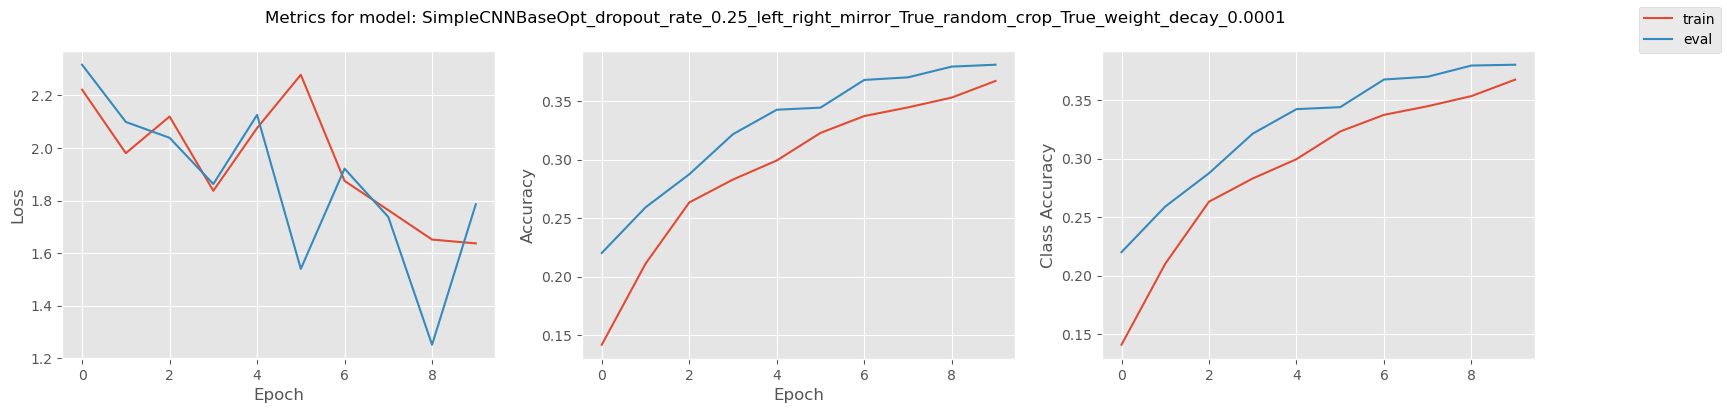

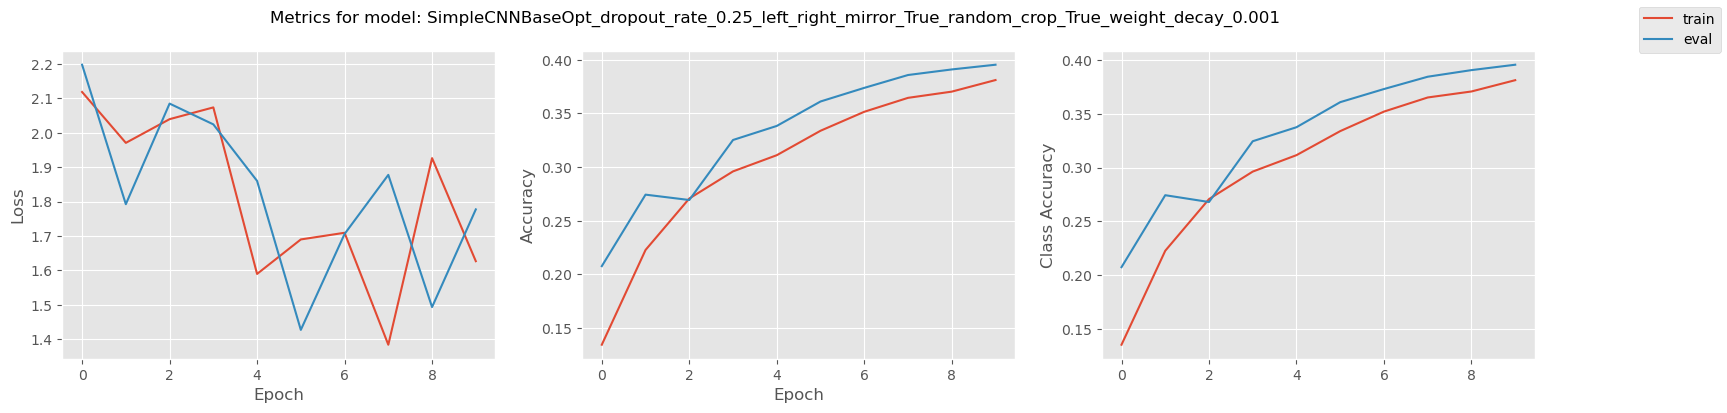

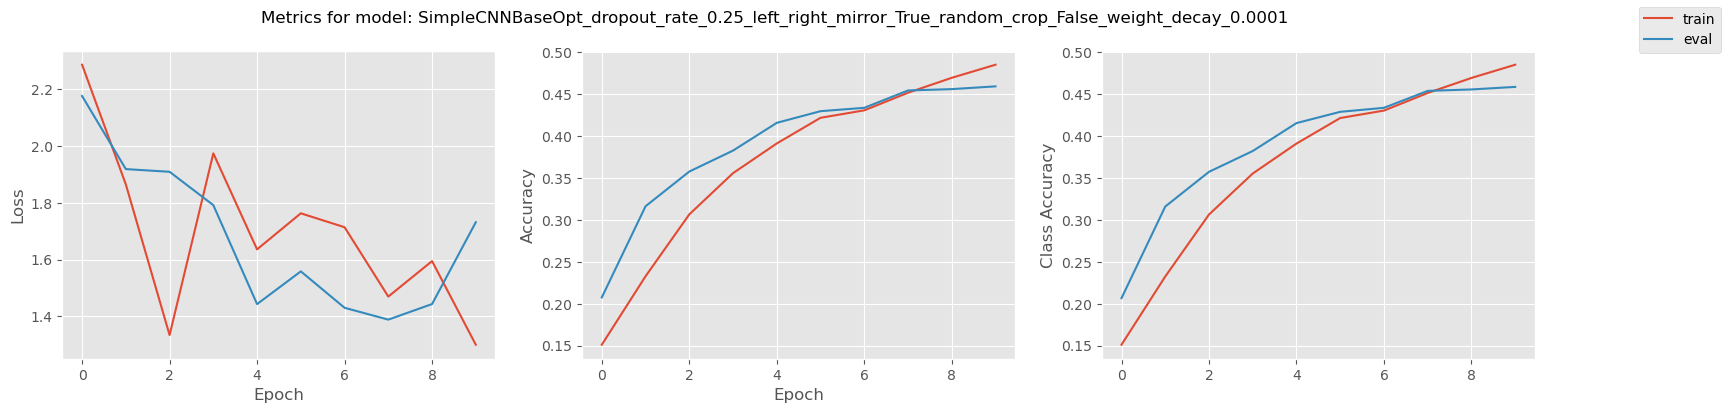

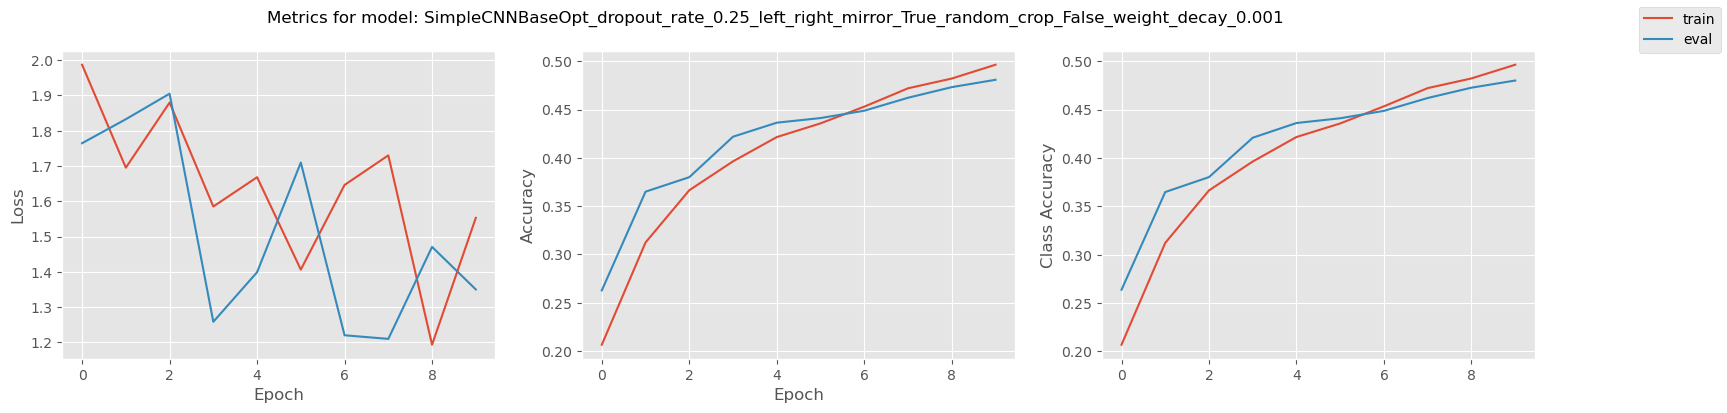

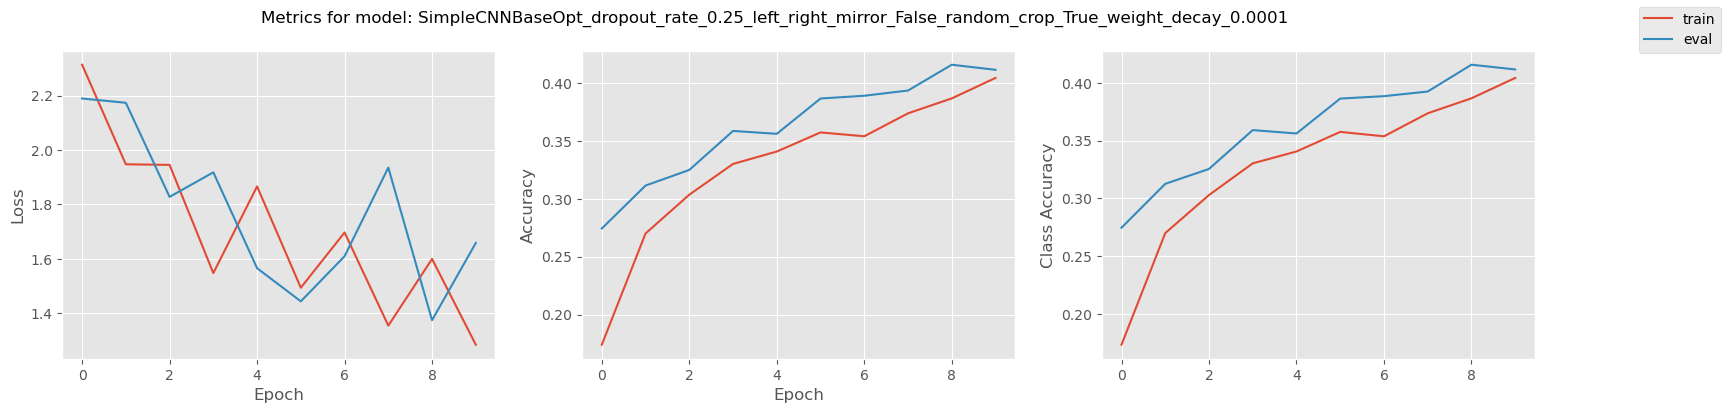

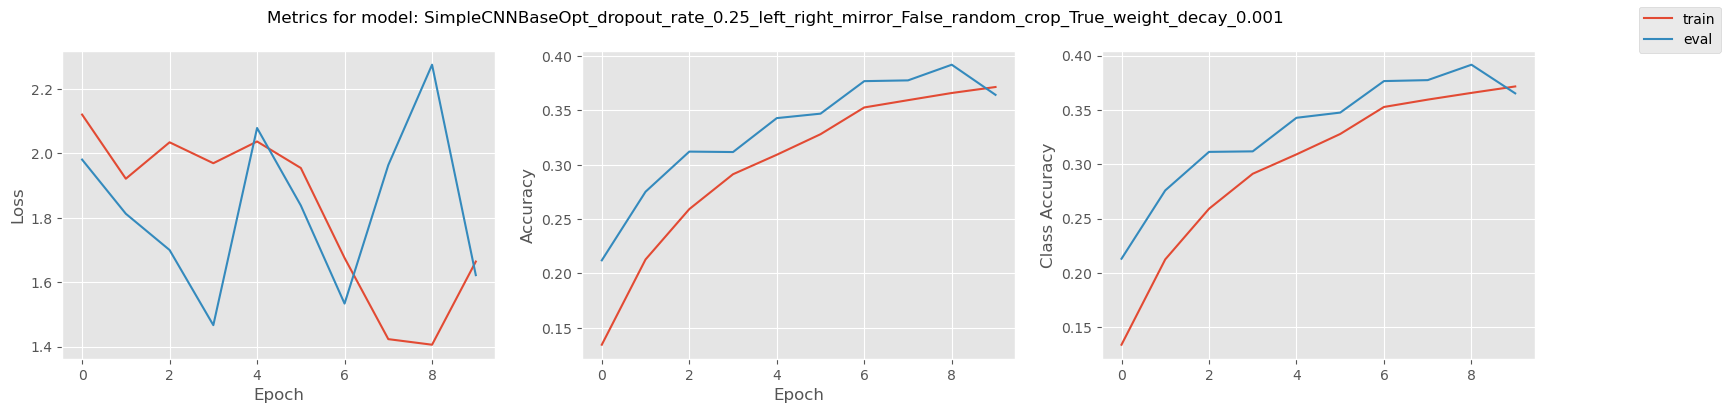

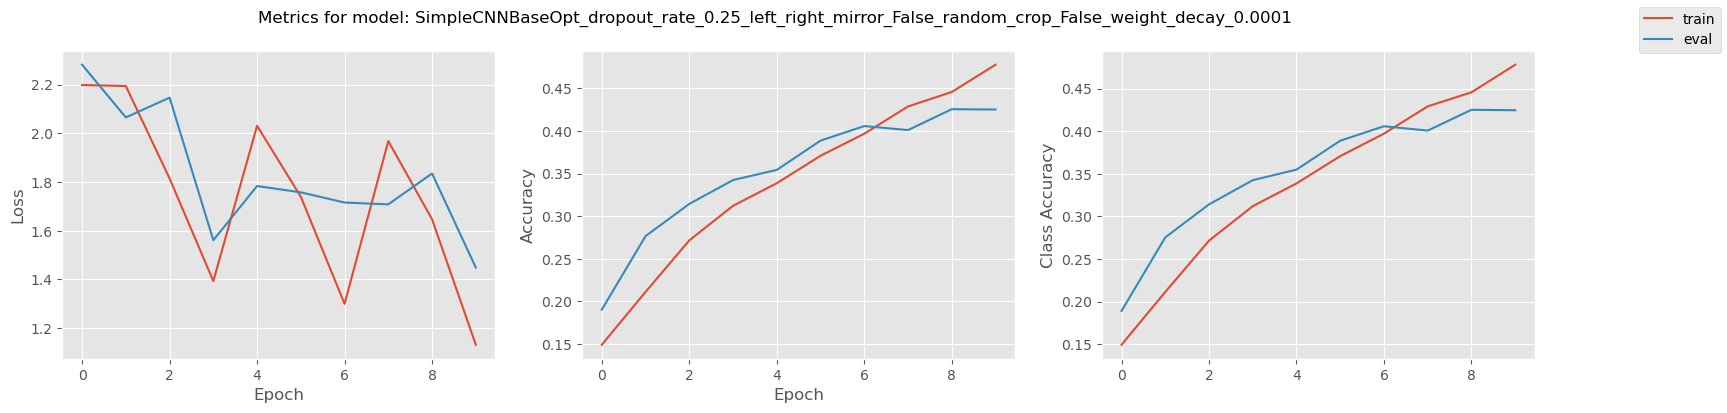

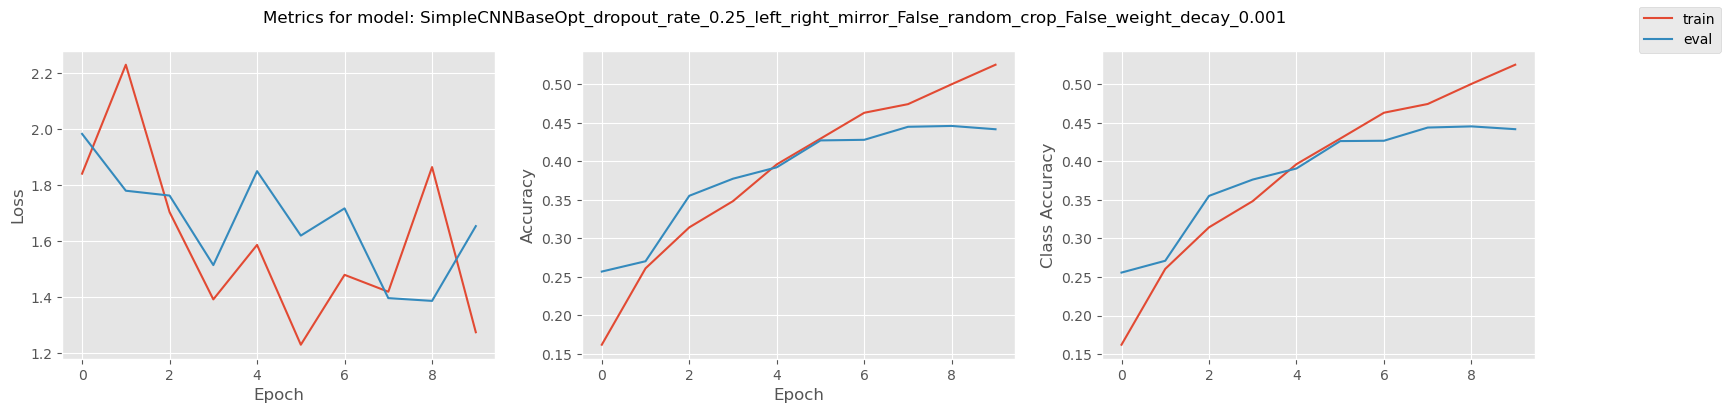

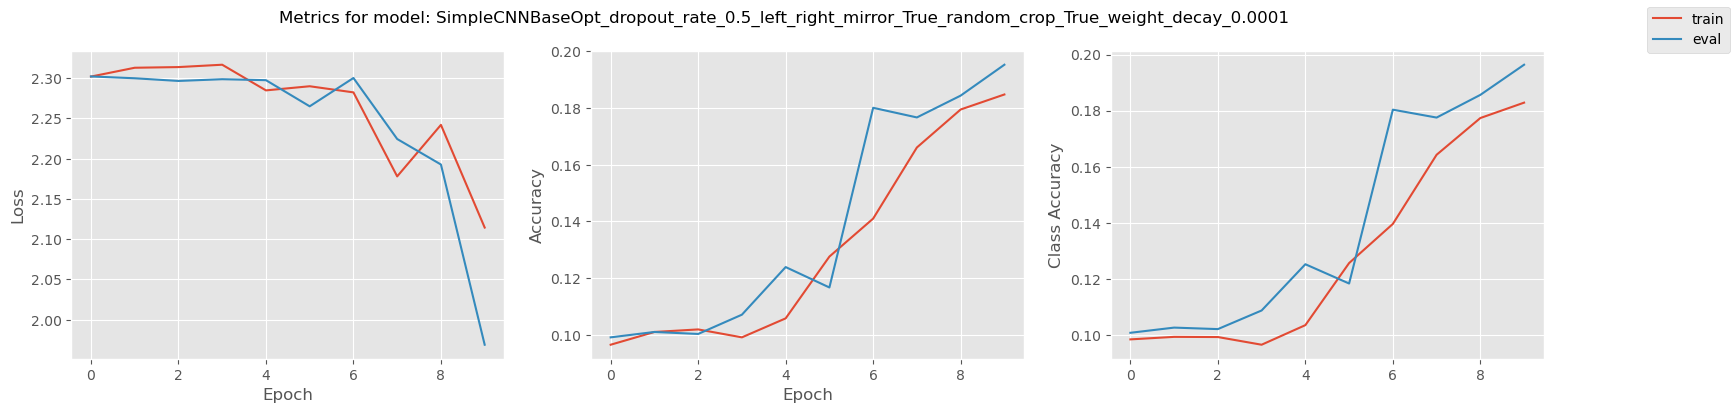

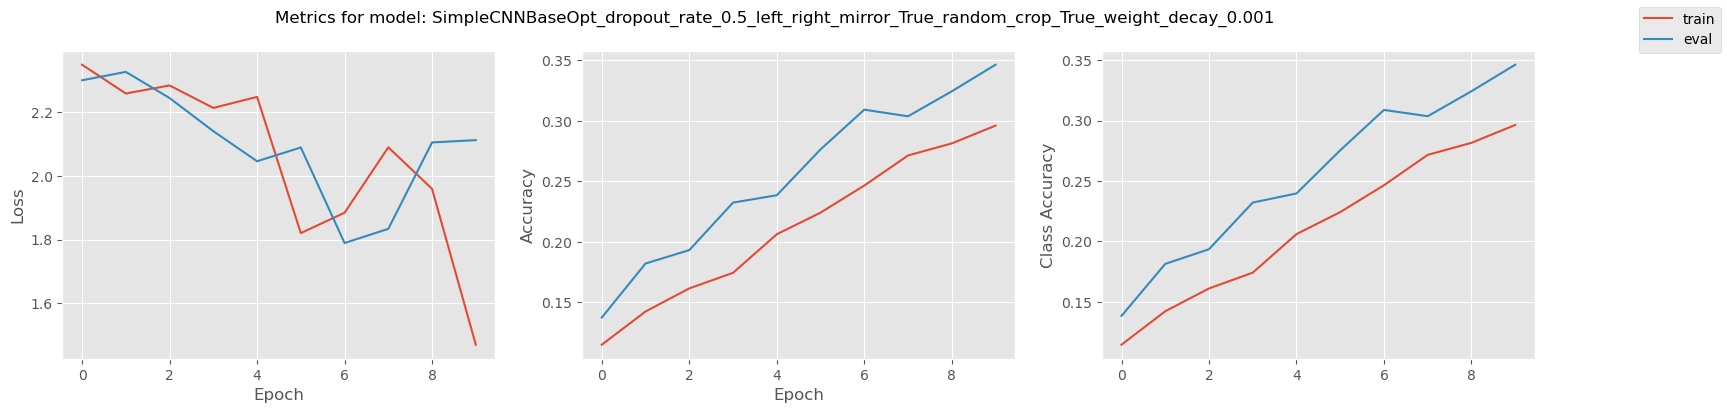

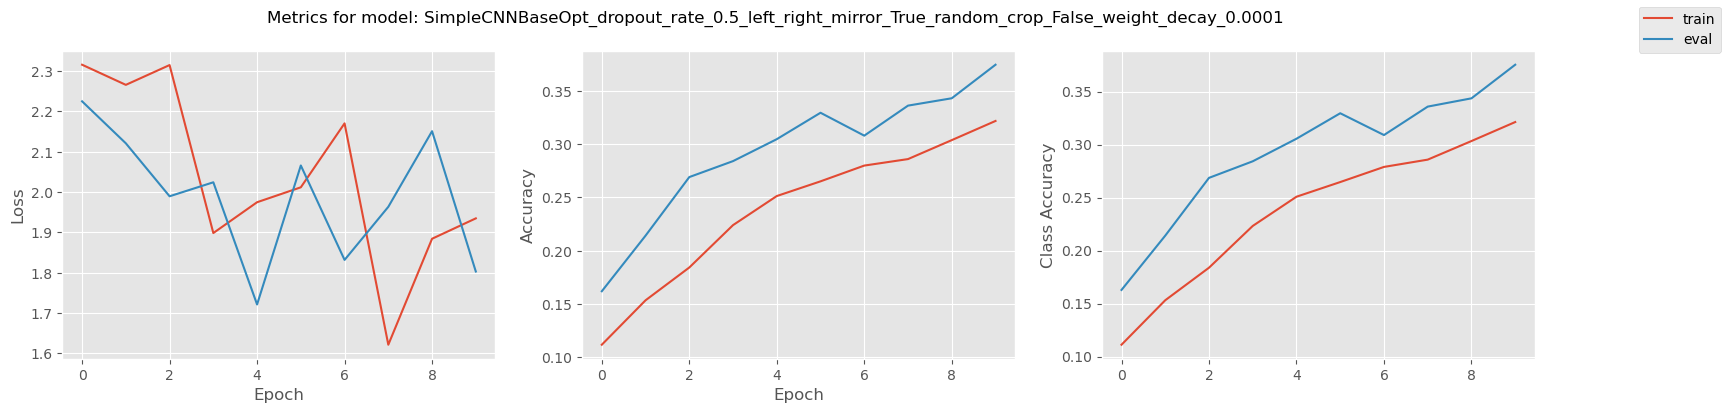

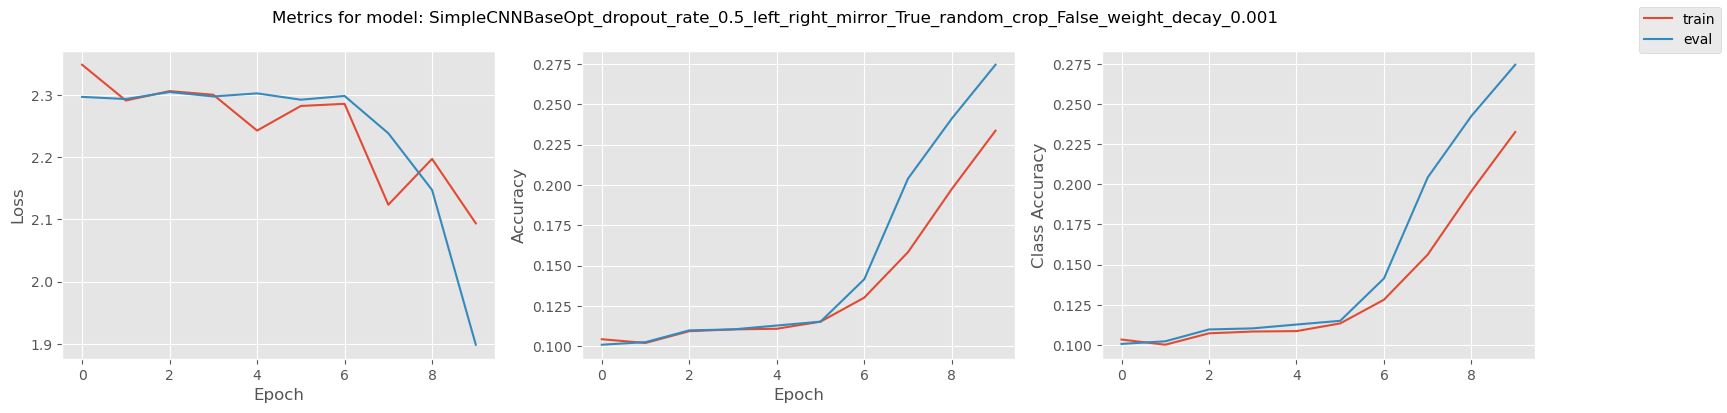

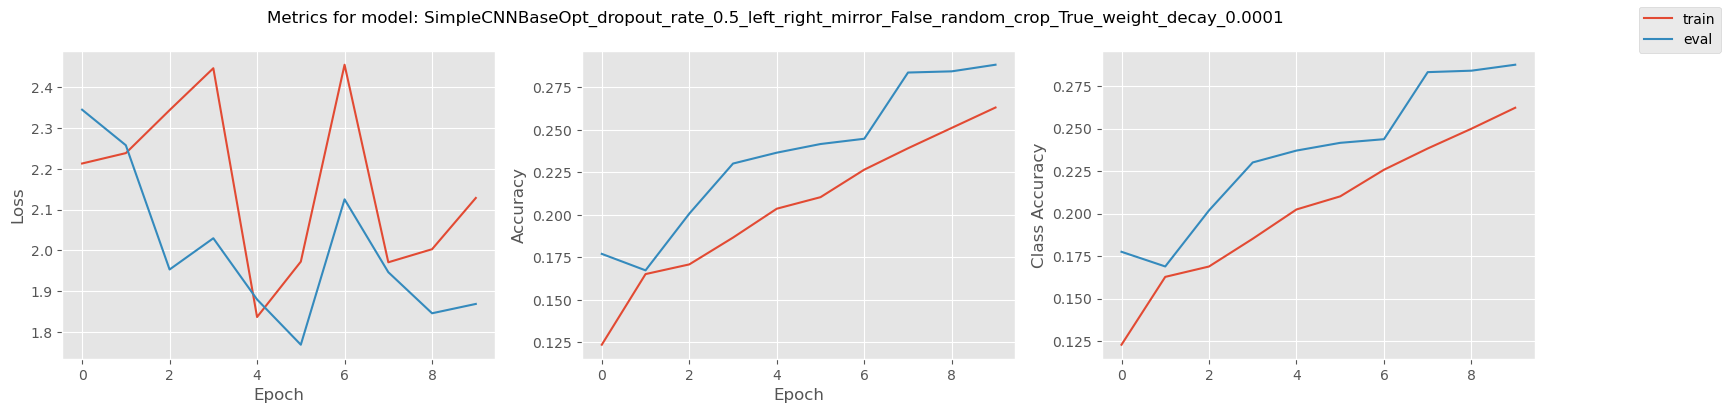

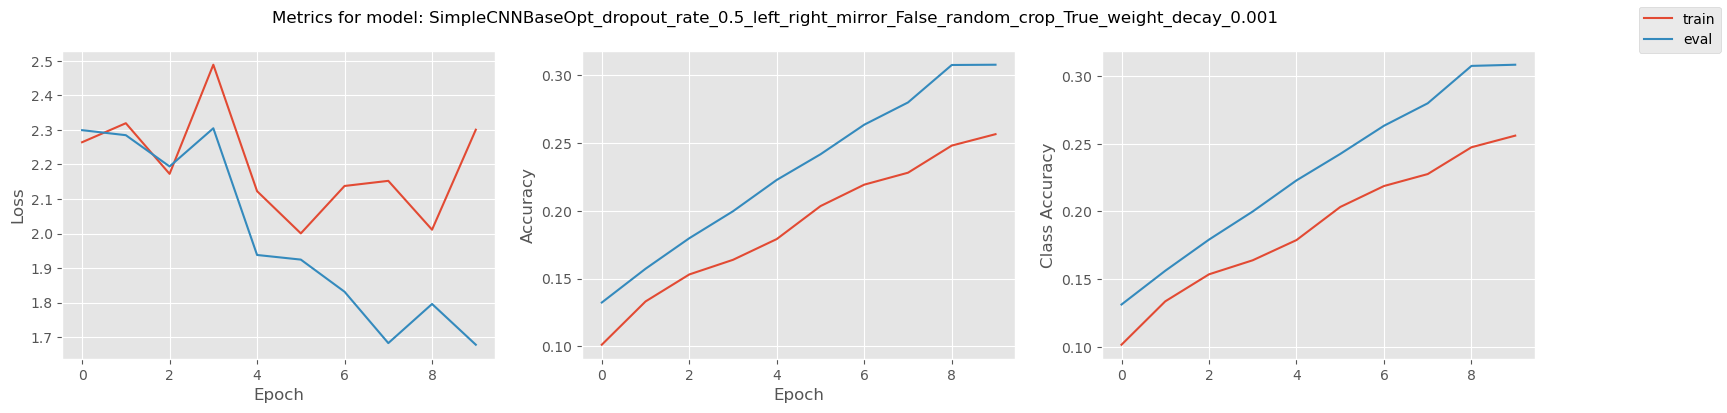

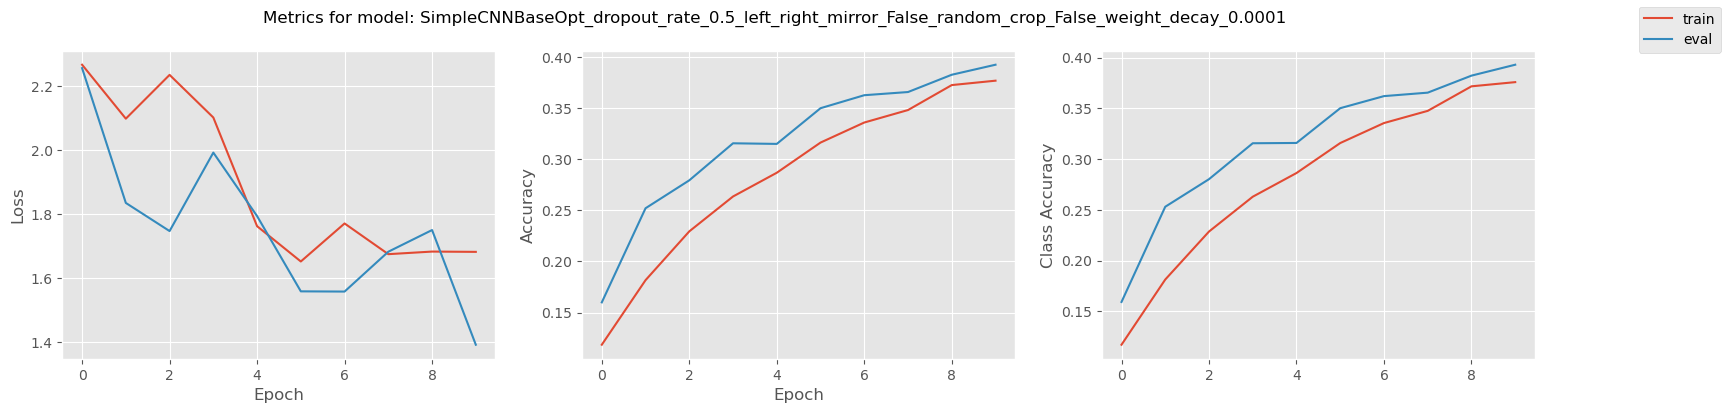

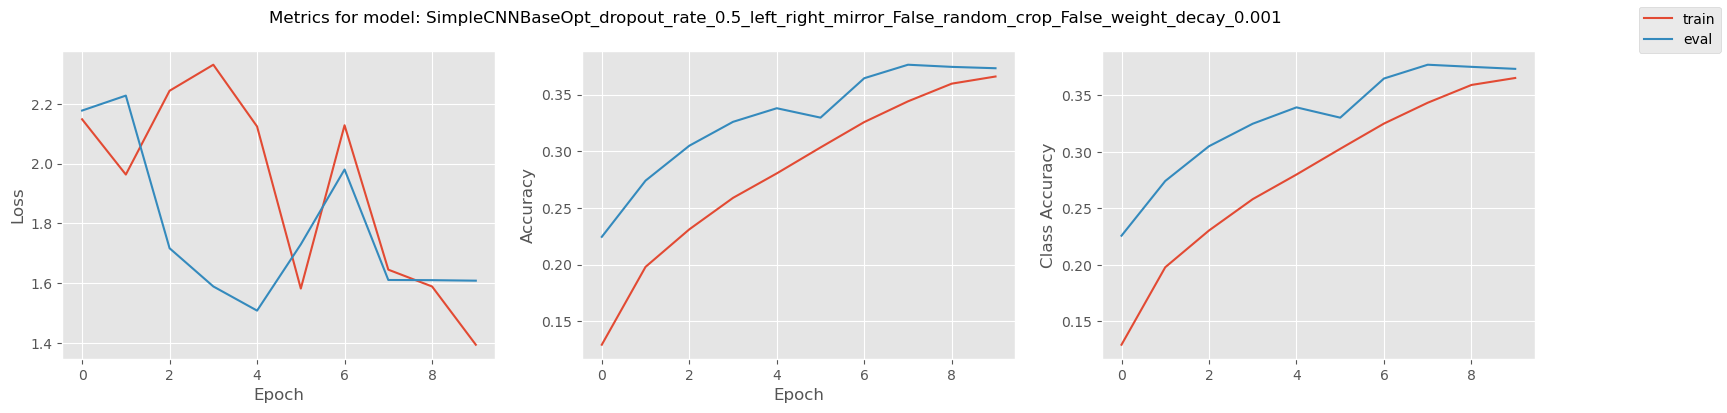

In [9]:
# Perform grid search for hyperparameter optimization

param_grid = {
    'random_crop': [True, False],
    'left_right_mirror': [True, False],
    'dropout_rate': [0.25, 0.5],
    'weight_decay': [0.0001, 0.001]
}

best_model_name = None
best_model = None
best_model_accuracy = 0.0
best_parameters = None

for i, params in enumerate(ParameterGrid(param_grid)):
        
    if params['random_crop'] == True and params['left_right_mirror'] == True:
        transform = v2.Compose([
            v2.ToImage(), 
            v2.RandomHorizontalFlip(),
            v2.RandomCrop(32, padding=4),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean = [0.485, 0.456,0.406], std = [0.229, 0.224, 0.225])
        ])
    elif params['random_crop'] == True and params['left_right_mirror'] == False:
        transform = v2.Compose([
            v2.ToImage(), 
            v2.RandomCrop(32, padding=4),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean = [0.485, 0.456,0.406], std = [0.229, 0.224, 0.225])
        ])
    elif params['random_crop'] == False and params['left_right_mirror'] == True:
        transform = v2.Compose([
            v2.ToImage(), 
            v2.RandomHorizontalFlip(),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean = [0.485, 0.456,0.406], std = [0.229, 0.224, 0.225])
        ])
    else:
        transform = v2.Compose([
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean = [0.485, 0.456,0.406], std = [0.229, 0.224, 0.225])
        ])

    train_data_opt, val_data_opt, test_data_opt = cifar_load(transform)

    model = SimpleCNNBaseOpt(dropout_rate=params['dropout_rate'])

    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=params['weight_decay'])

    print(f'\n\n{i+1}/{len(ParameterGrid(param_grid))} Training model with hyperparameters: {params}')

    name = model.__class__.__name__

    for param in params:
        name += "_"+param + "_" + str(params[param])

    trainer = train_model_opt(model, optimizer, name, train_data_opt, val_data_opt)

    trainer.train()

    model, test_metric = test_model(model, params, test_data_opt)

    plot_metrics(trainer, name)

    if test_metric.accuracy() > best_model_accuracy:
        best_model_accuracy = test_metric.accuracy()
        best_parameters = params
        best_model = model
        best_model_name = name

print("Model:", best_model_name)
print("Best model found with parameters:", best_parameters)
print("Best test accuracy:", best_model_accuracy)



1/16 Training model with hyperparameters: {'dropout_rate': 0.25, 'left_right_mirror': True, 'random_crop': True, 'weight_decay': 0.0001}

Training model:  DeepCNNOpt

TRAIN, EPOCH: 0 
Loss: 2.187941312789917
Accuracy: 0.2112
Class Accuracy: 0.2113923080265522

VALIDATION, EPOCH: 0 
Loss: 2.010801076889038
Accuracy: 0.2877
Class Accuracy: 0.2880426421761513
Best mean per class accuracy on validation data set is higher. Saving new best model

TRAIN, EPOCH: 1 
Loss: 1.6934179067611694
Accuracy: 0.3176
Class Accuracy: 0.3178686387836933

VALIDATION, EPOCH: 1 
Loss: 1.930138111114502
Accuracy: 0.3642
Class Accuracy: 0.3642309054732323
Best mean per class accuracy on validation data set is higher. Saving new best model

TRAIN, EPOCH: 2 
Loss: 2.0866546630859375
Accuracy: 0.3545
Class Accuracy: 0.35520843118429185

VALIDATION, EPOCH: 2 
Loss: 1.36472749710083
Accuracy: 0.4058
Class Accuracy: 0.405109865963459
Best mean per class accuracy on validation data set is higher. Saving new best mod

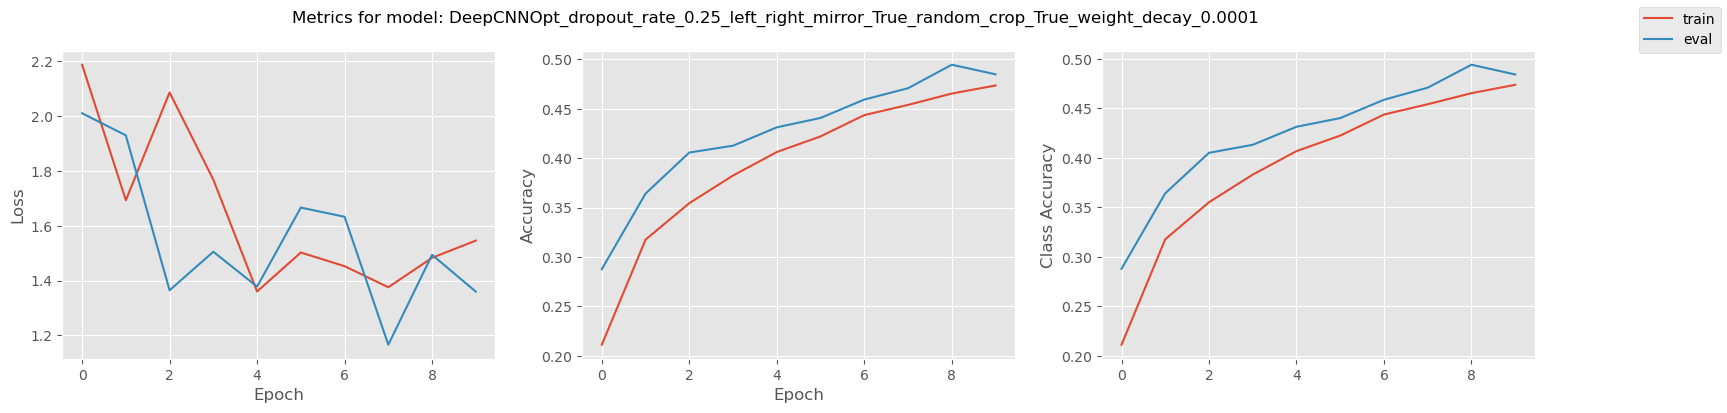

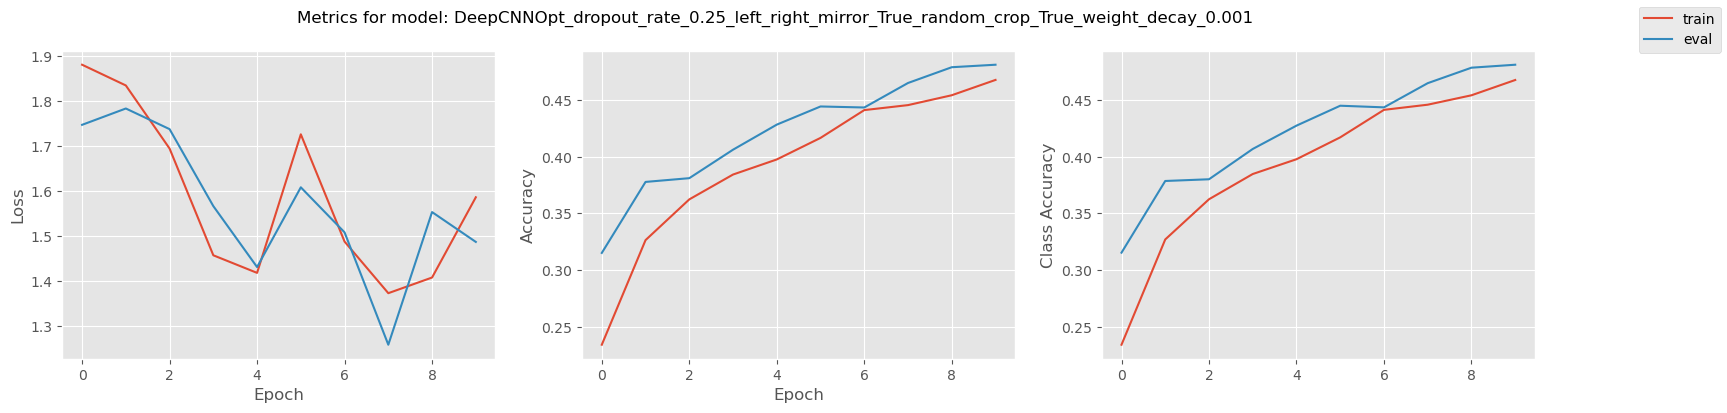

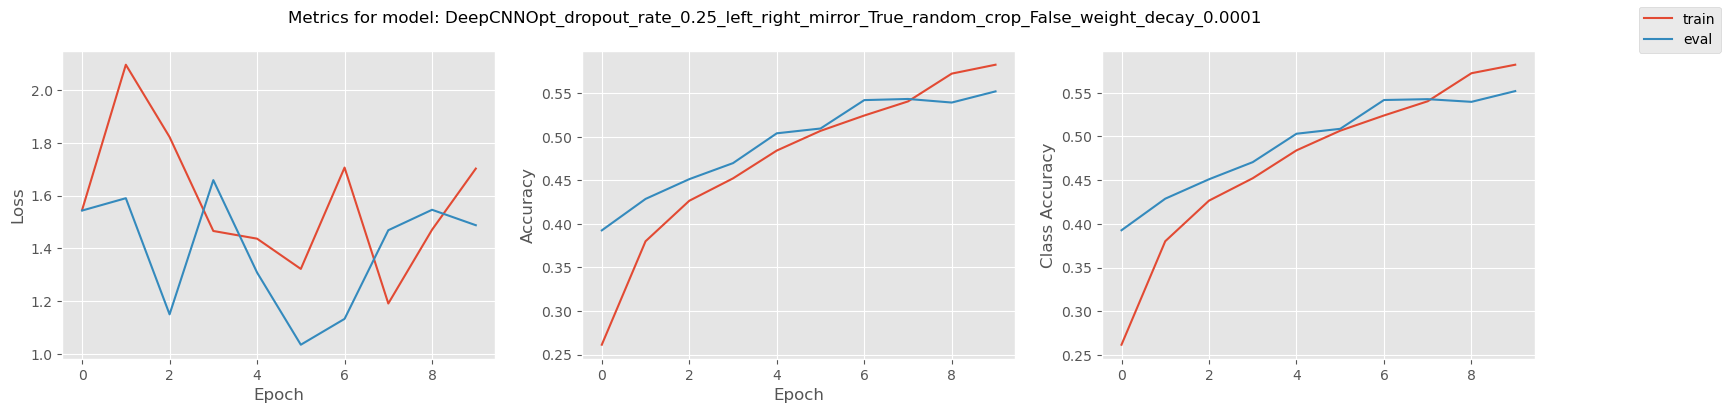

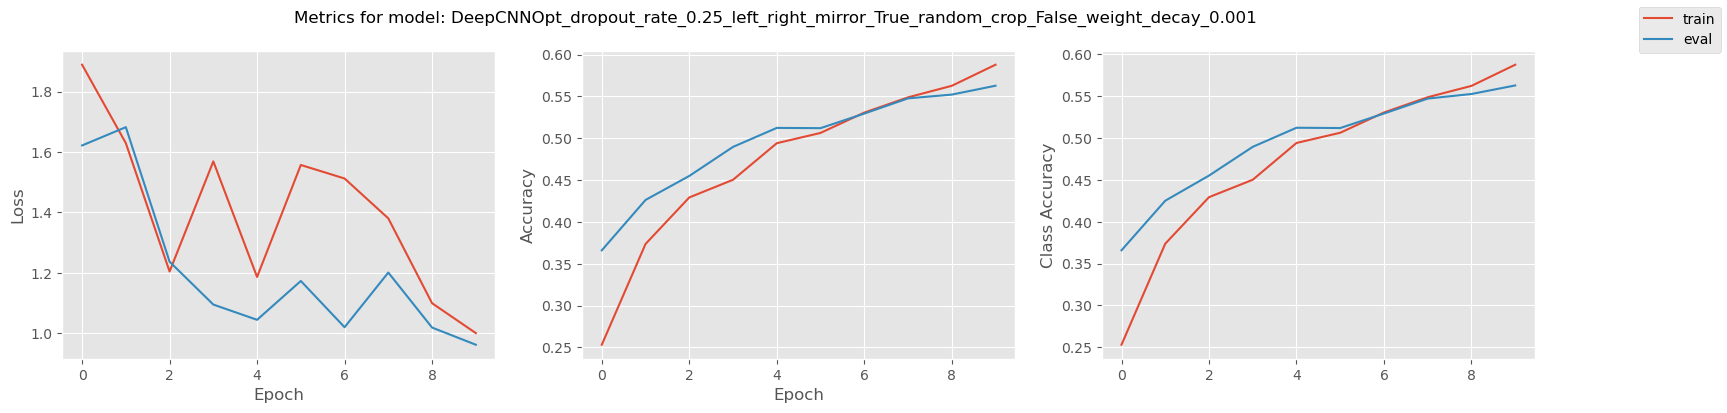

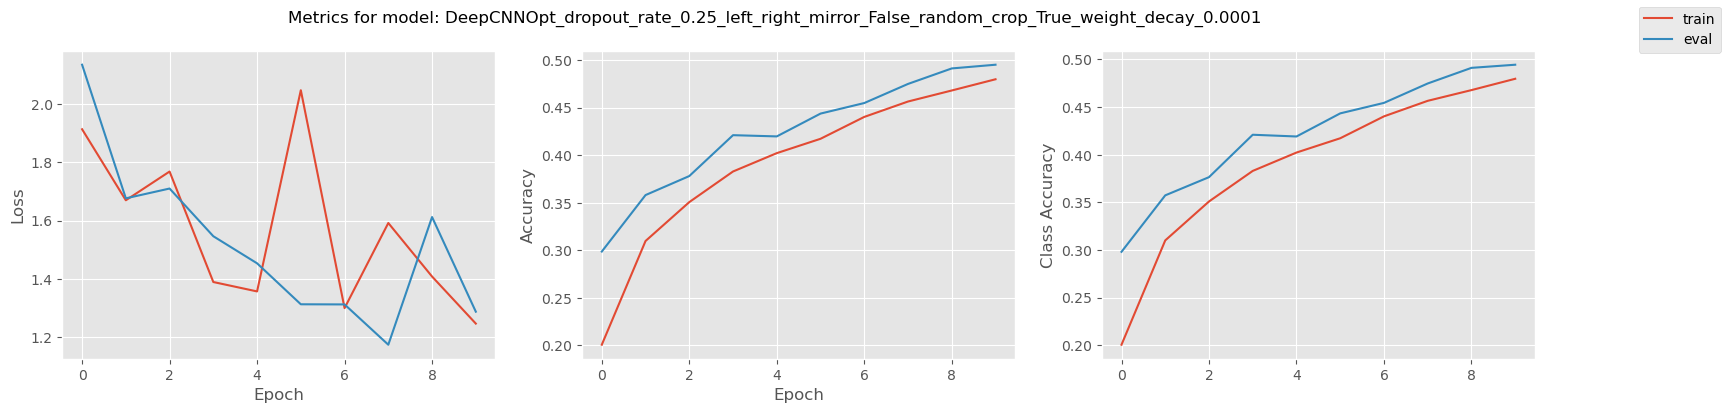

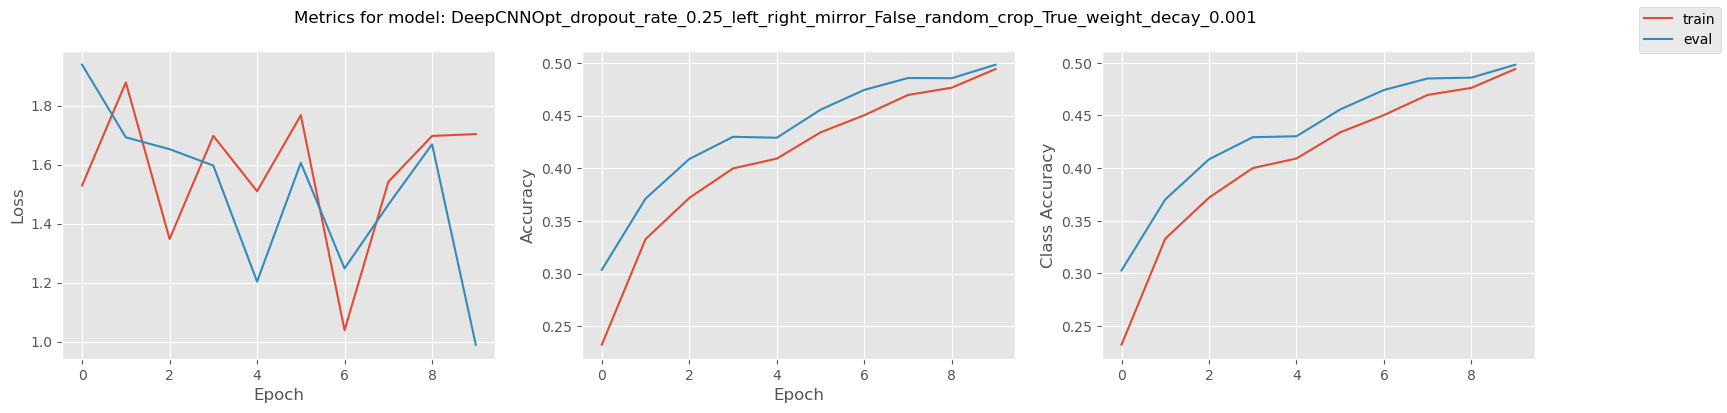

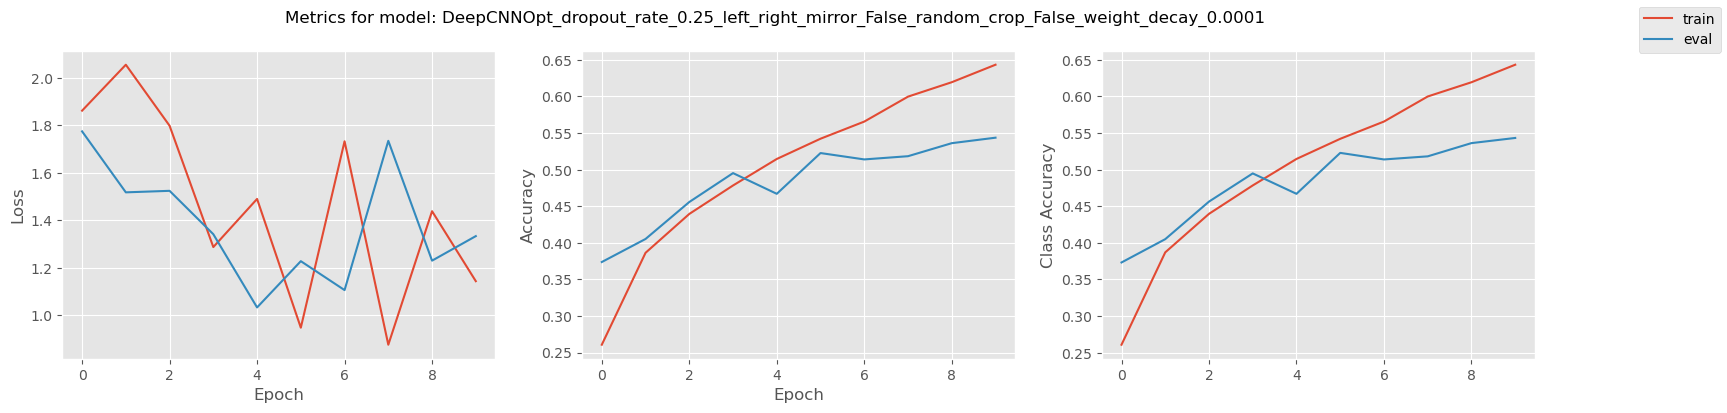

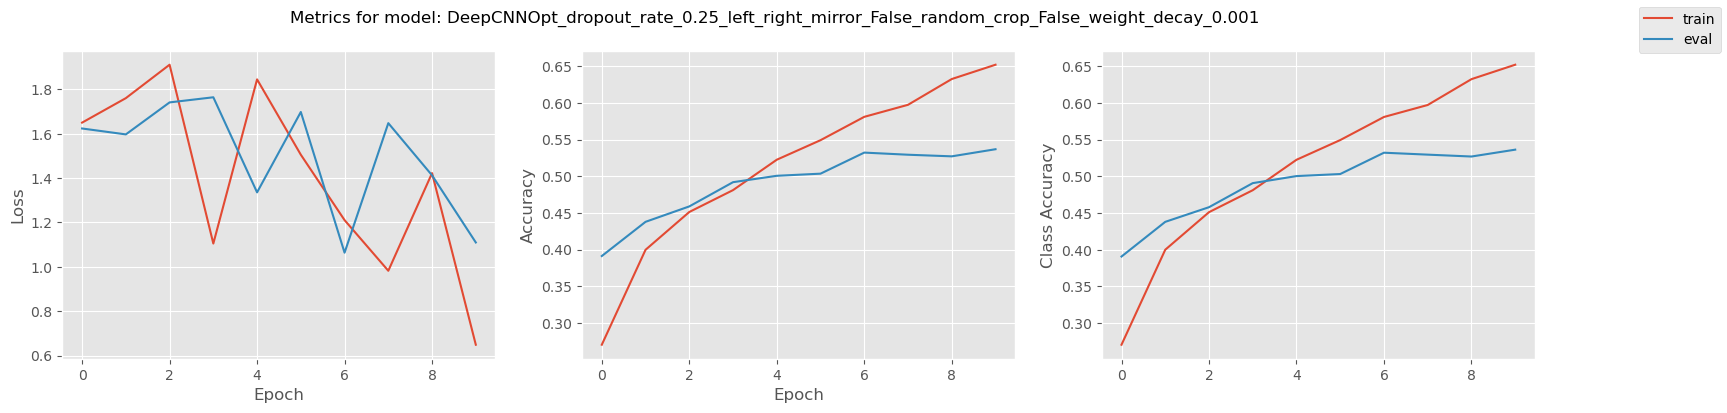

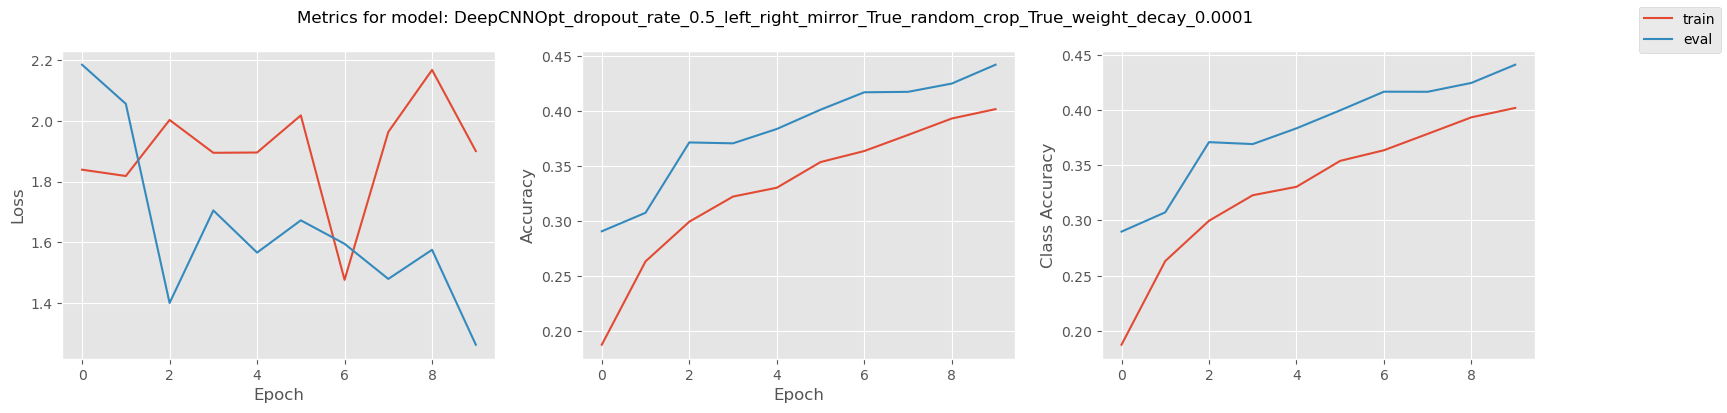

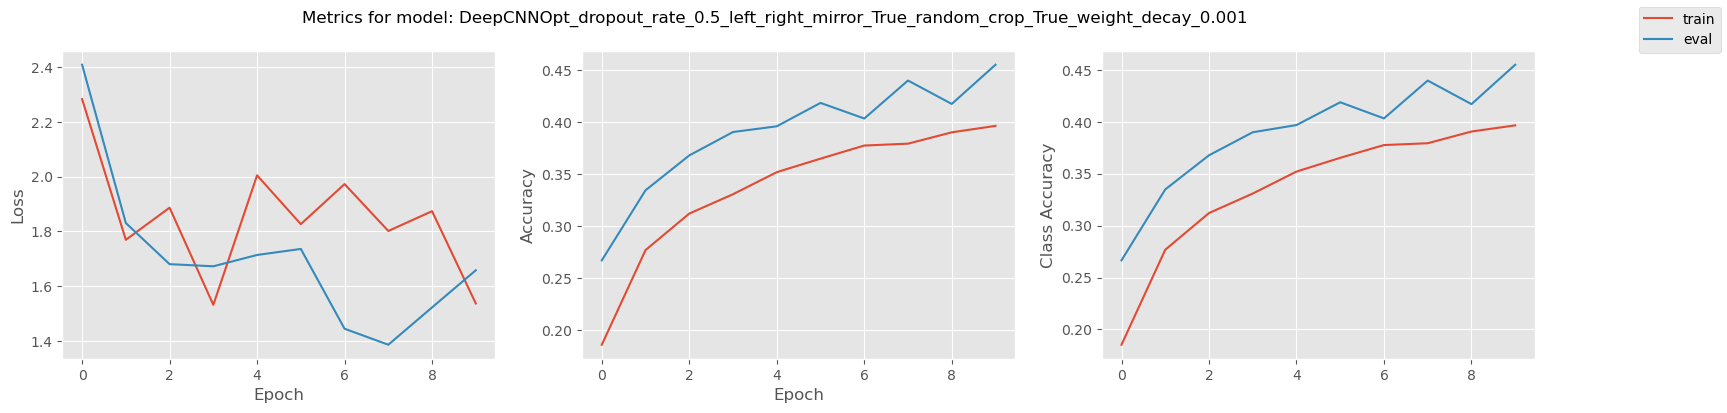

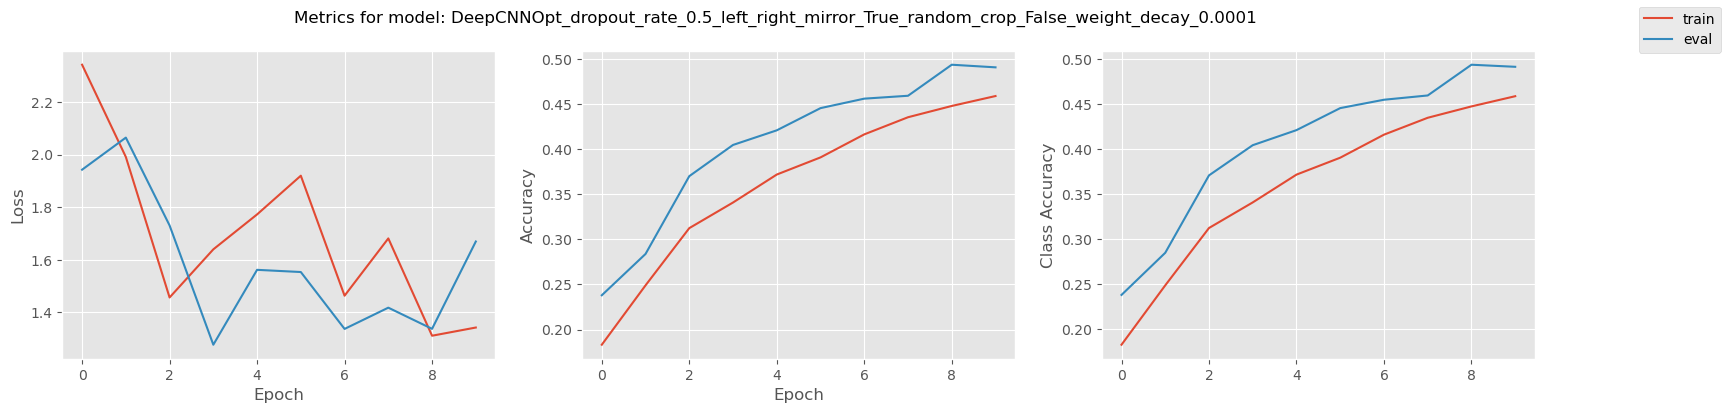

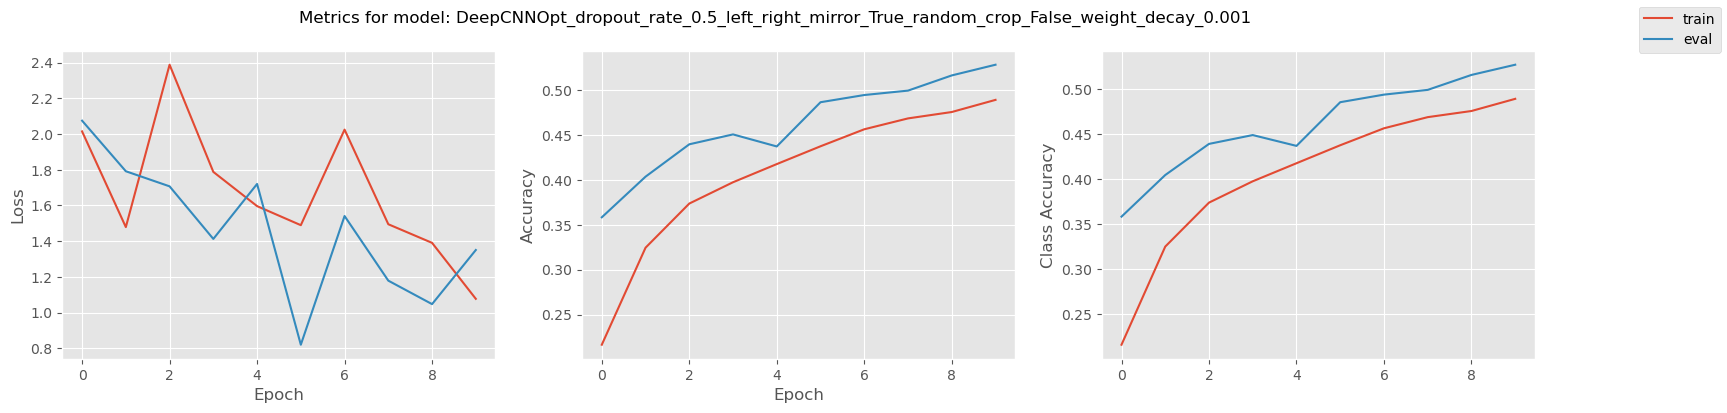

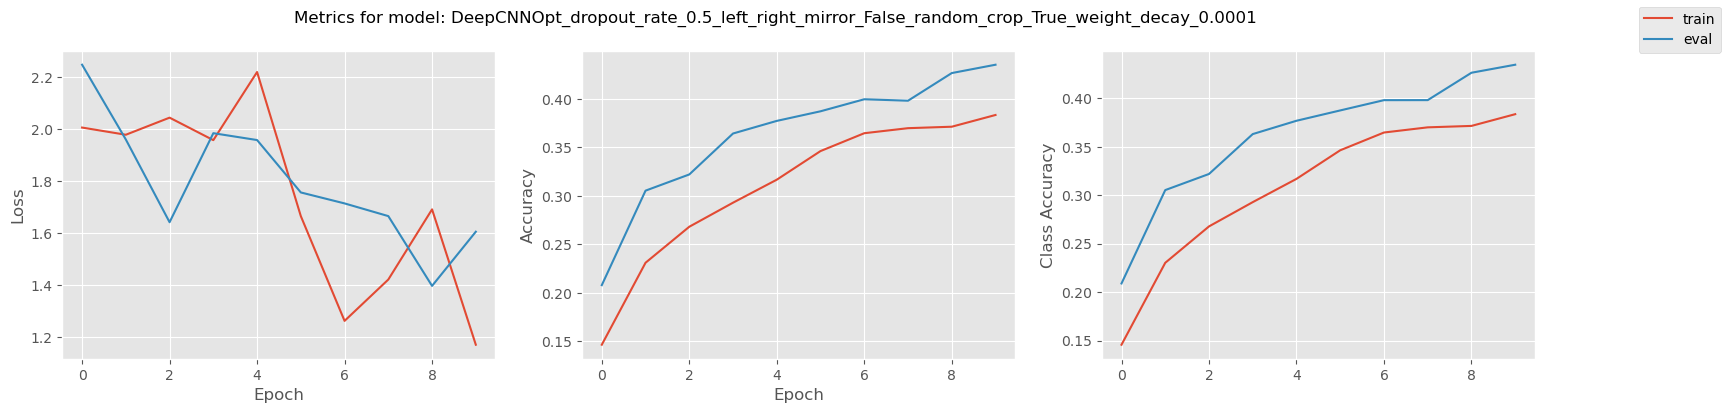

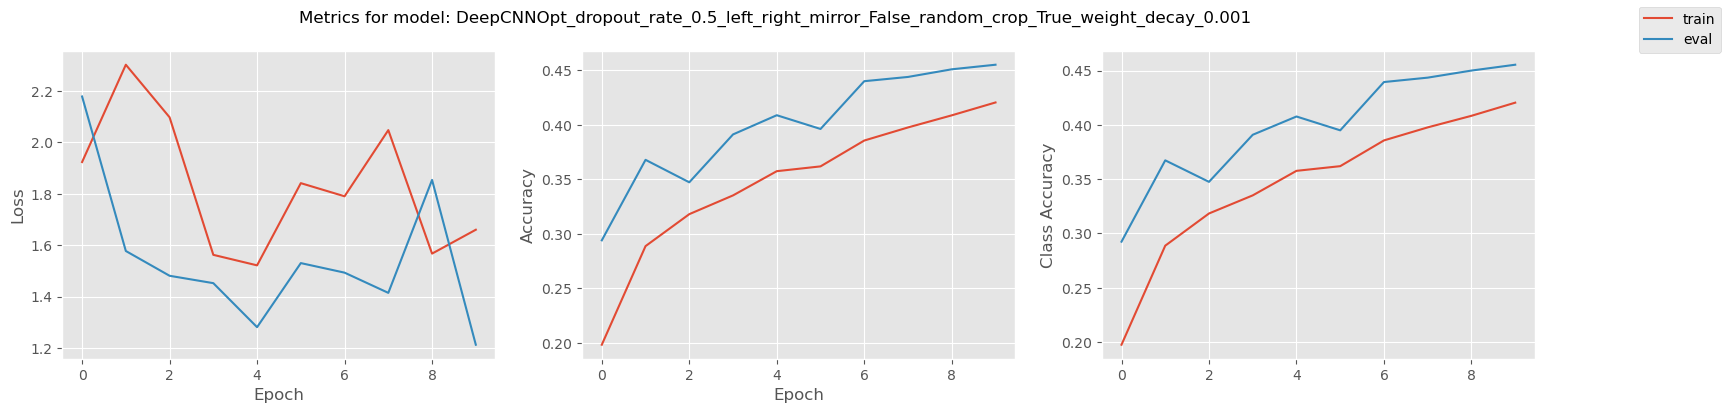

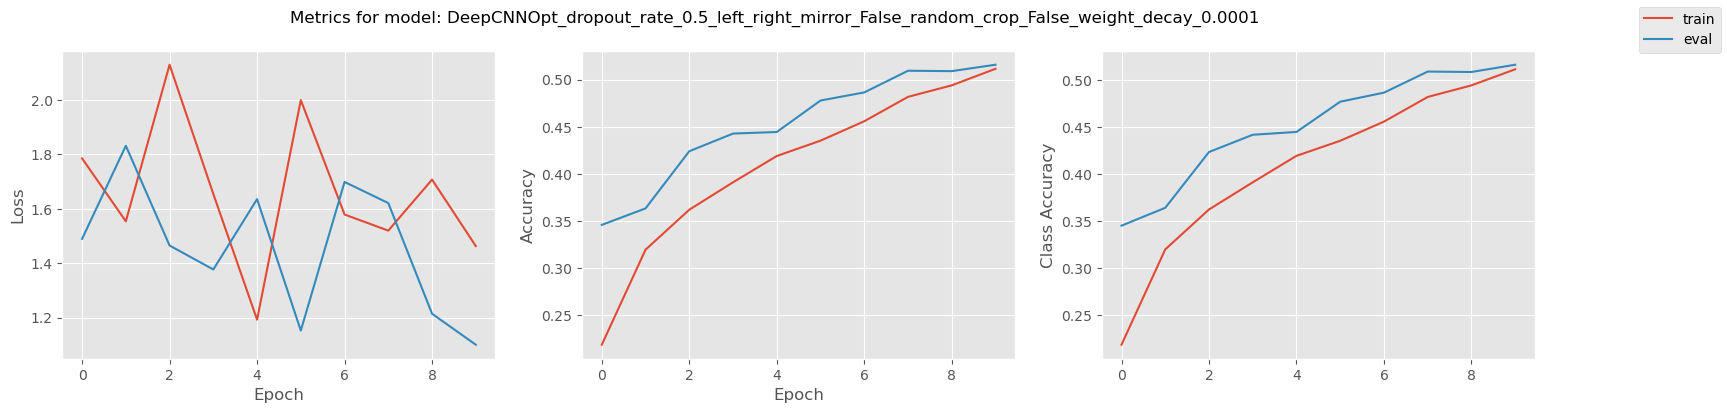

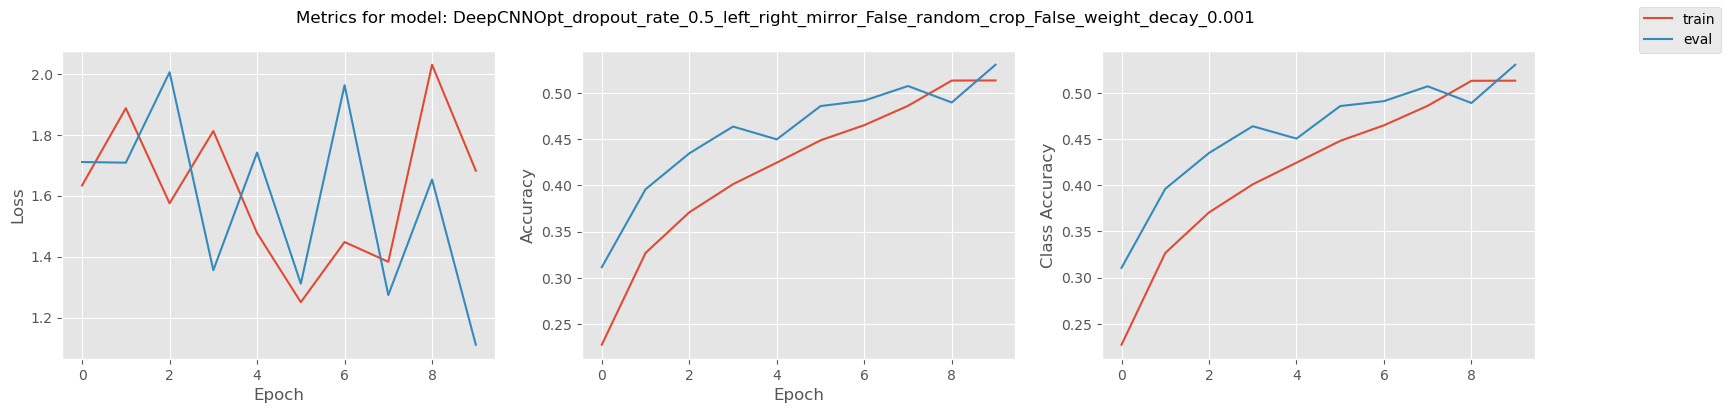

In [10]:
# Perform grid search for hyperparameter optimization

param_grid = {
    'random_crop': [True, False],
    'left_right_mirror': [True, False],
    'dropout_rate': [0.25, 0.5],
    'weight_decay': [0.0001, 0.001]
}

best_model_name = None
best_model = None
best_model_accuracy = 0.0
best_parameters = None


for i, params in enumerate(ParameterGrid(param_grid)):
        
    if params['random_crop'] == True and params['left_right_mirror'] == True:
        transform = v2.Compose([
            v2.ToImage(), 
            v2.RandomHorizontalFlip(),
            v2.RandomCrop(32, padding=4),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean = [0.485, 0.456,0.406], std = [0.229, 0.224, 0.225])
        ])
    elif params['random_crop'] == True and params['left_right_mirror'] == False:
        transform = v2.Compose([
            v2.ToImage(), 
            v2.RandomCrop(32, padding=4),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean = [0.485, 0.456,0.406], std = [0.229, 0.224, 0.225])
        ])
    elif params['random_crop'] == False and params['left_right_mirror'] == True:
        transform = v2.Compose([
            v2.ToImage(), 
            v2.RandomHorizontalFlip(),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean = [0.485, 0.456,0.406], std = [0.229, 0.224, 0.225])
        ])
    else:
        transform = v2.Compose([
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean = [0.485, 0.456,0.406], std = [0.229, 0.224, 0.225])
        ])

    train_data_opt, val_data_opt, test_data_opt = cifar_load(transform)

    model = DeepCNNOpt(dropout_rate=params['dropout_rate'])

    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=params['weight_decay'])

    print(f'\n\n{i+1}/{len(ParameterGrid(param_grid))} Training model with hyperparameters: {params}')

    name = model.__class__.__name__

    for param in params:
        name += "_"+param + "_" + str(params[param])

    trainer = train_model_opt(model, optimizer, name, train_data_opt, val_data_opt)

    trainer.train()

    model, test_metric = test_model(model, params, test_data_opt)


    plot_metrics(trainer, name)

    if test_metric.accuracy() > best_model_accuracy:
        best_model_accuracy = test_metric.accuracy()
        best_parameters = params
        best_model = model
        best_model_name = name

print("Model:", best_model_name)
print("Best model found with parameters:", best_parameters)
print("Best test accuracy:", best_model_accuracy)




1/16 Training model with hyperparameters: {'dropout_rate': 0.25, 'left_right_mirror': True, 'random_crop': True, 'weight_decay': 0.0001}

Training model:  DeepNormalizedCNNOpt

TRAIN, EPOCH: 0 
Loss: 1.764967441558838
Accuracy: 0.3227
Class Accuracy: 0.322593192756176

VALIDATION, EPOCH: 0 
Loss: 1.3928180932998657
Accuracy: 0.3783
Class Accuracy: 0.3775882638990879
Best mean per class accuracy on validation data set is higher. Saving new best model

TRAIN, EPOCH: 1 
Loss: 1.4506999254226685
Accuracy: 0.4216
Class Accuracy: 0.42158905863761903

VALIDATION, EPOCH: 1 
Loss: 1.3181378841400146
Accuracy: 0.4515
Class Accuracy: 0.4510050818324089
Best mean per class accuracy on validation data set is higher. Saving new best model

TRAIN, EPOCH: 2 
Loss: 1.5196971893310547
Accuracy: 0.4551
Class Accuracy: 0.4547823280096054

VALIDATION, EPOCH: 2 
Loss: 1.0554757118225098
Accuracy: 0.4826
Class Accuracy: 0.48174944818019866
Best mean per class accuracy on validation data set is higher. Savi

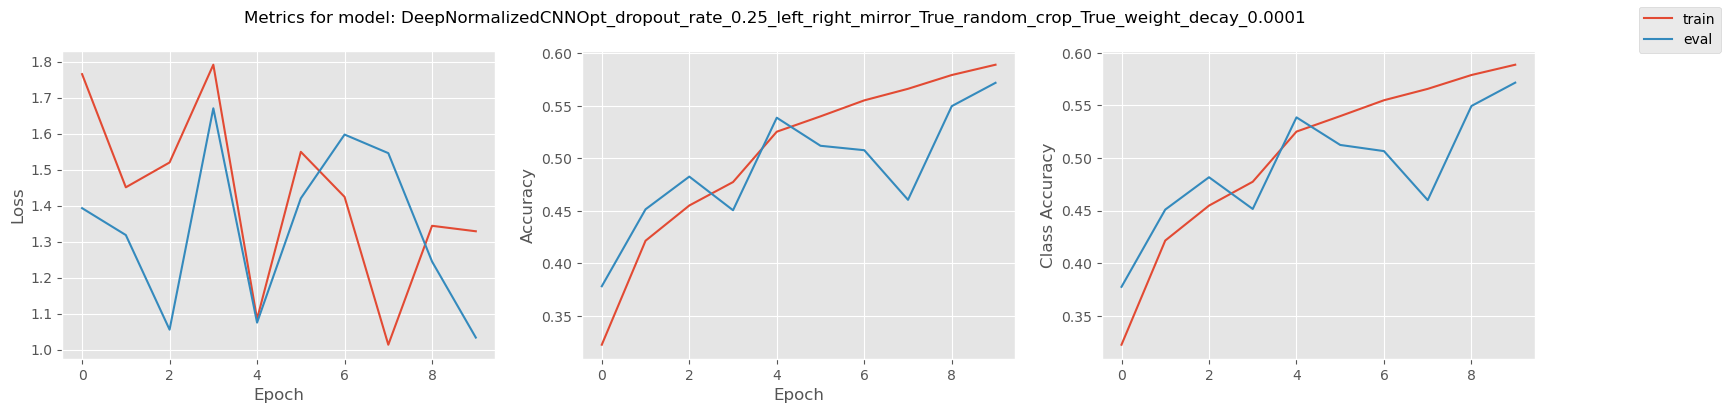

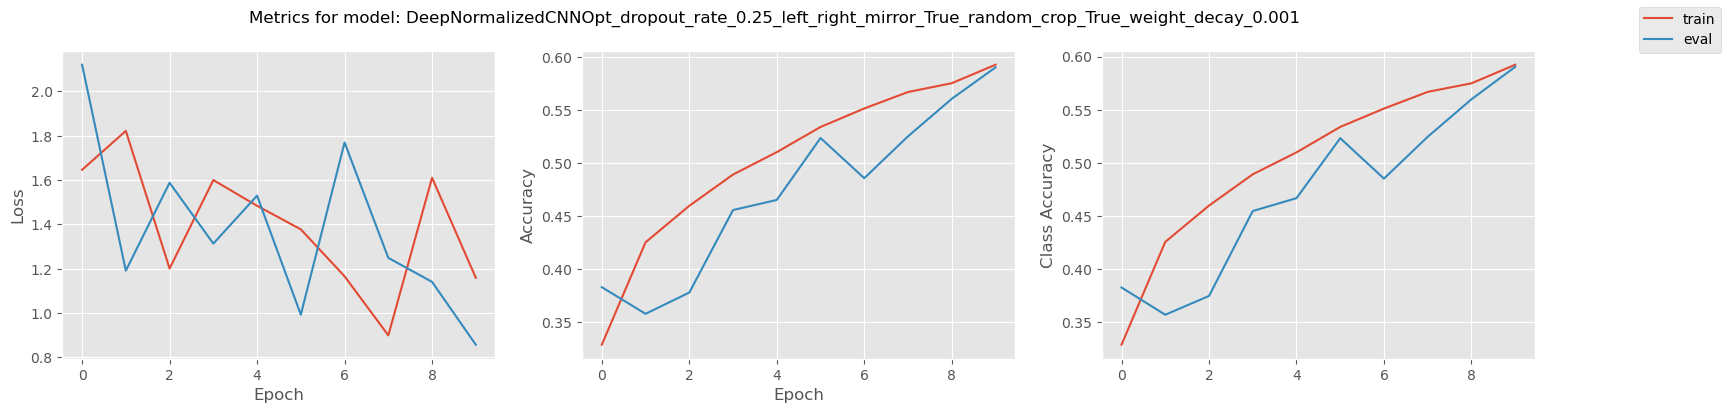

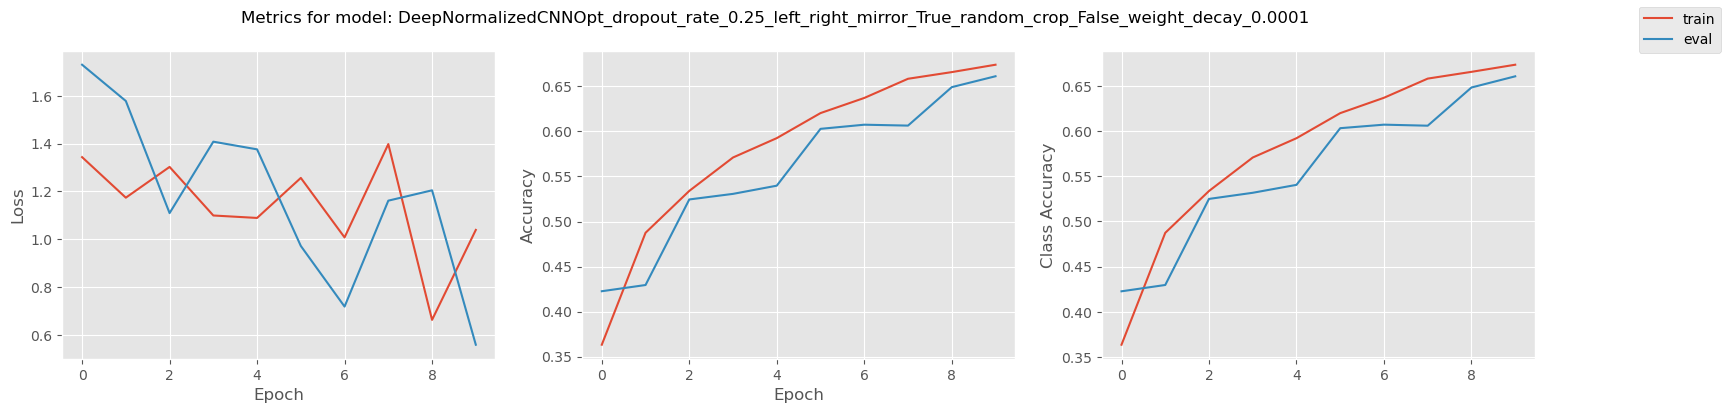

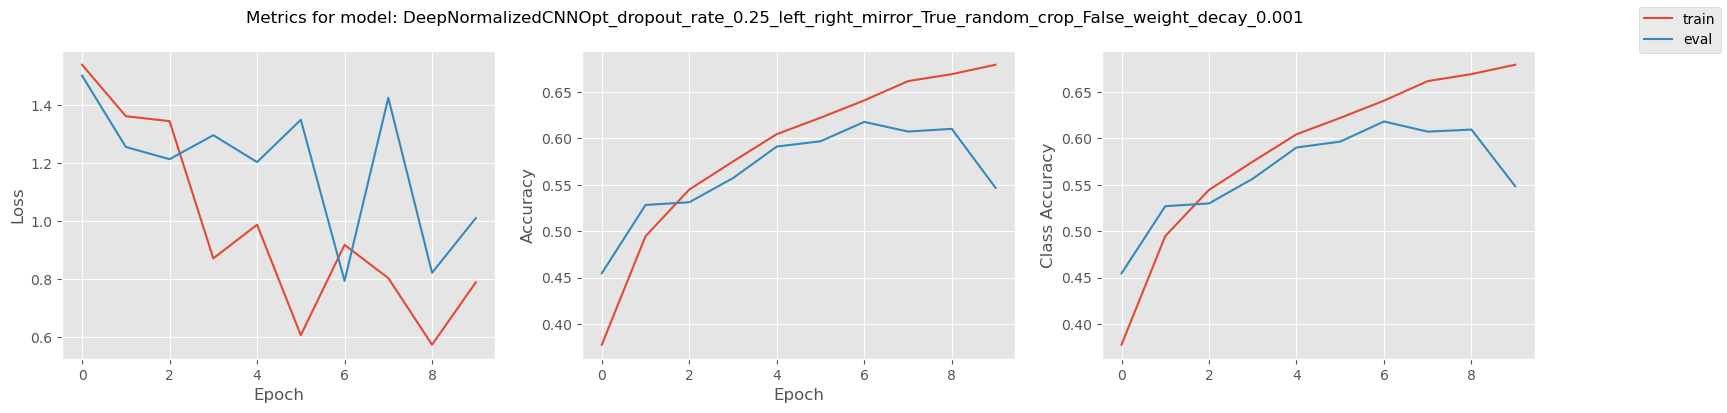

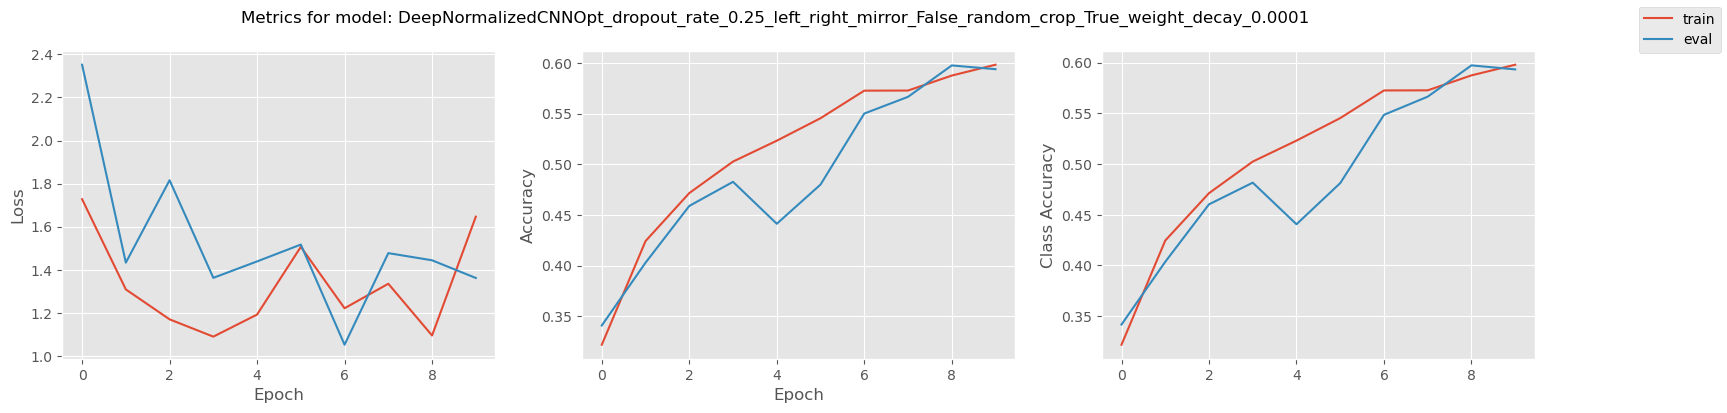

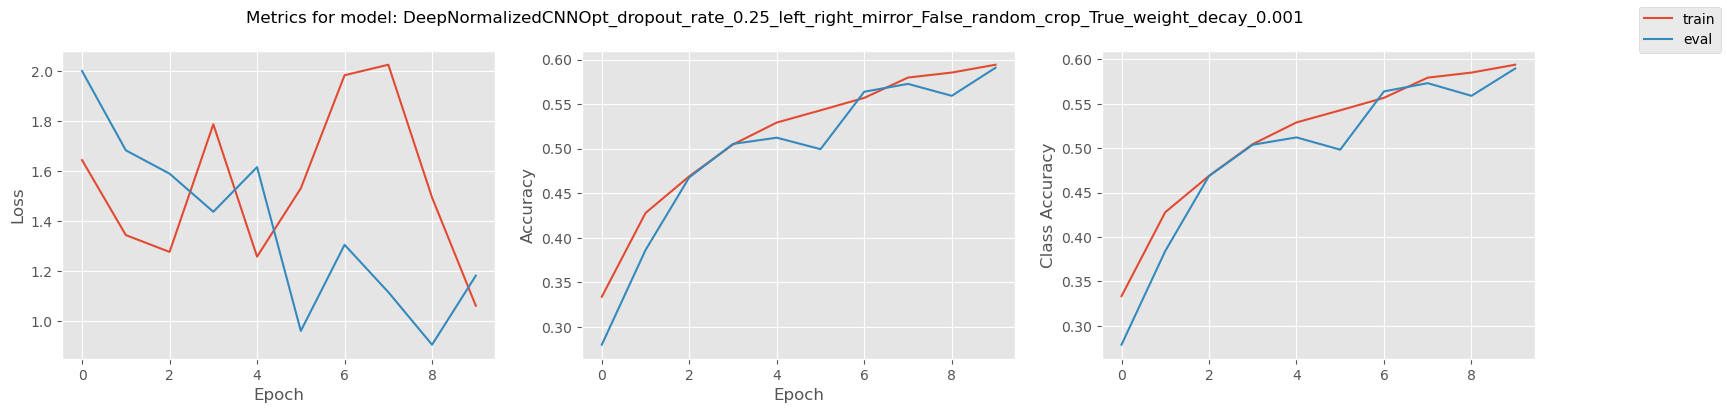

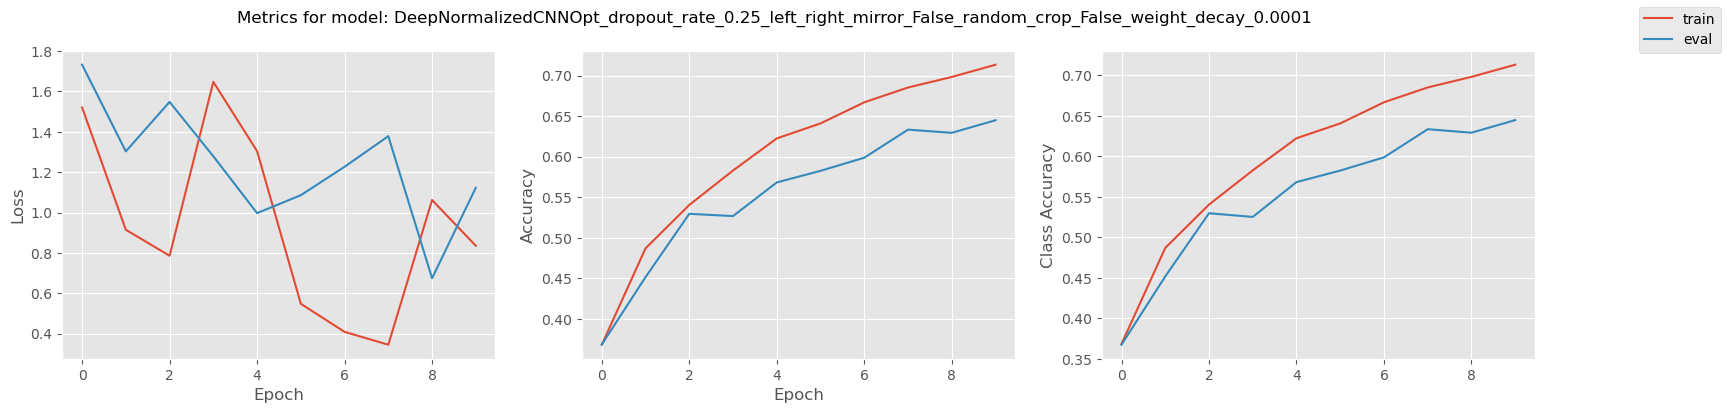

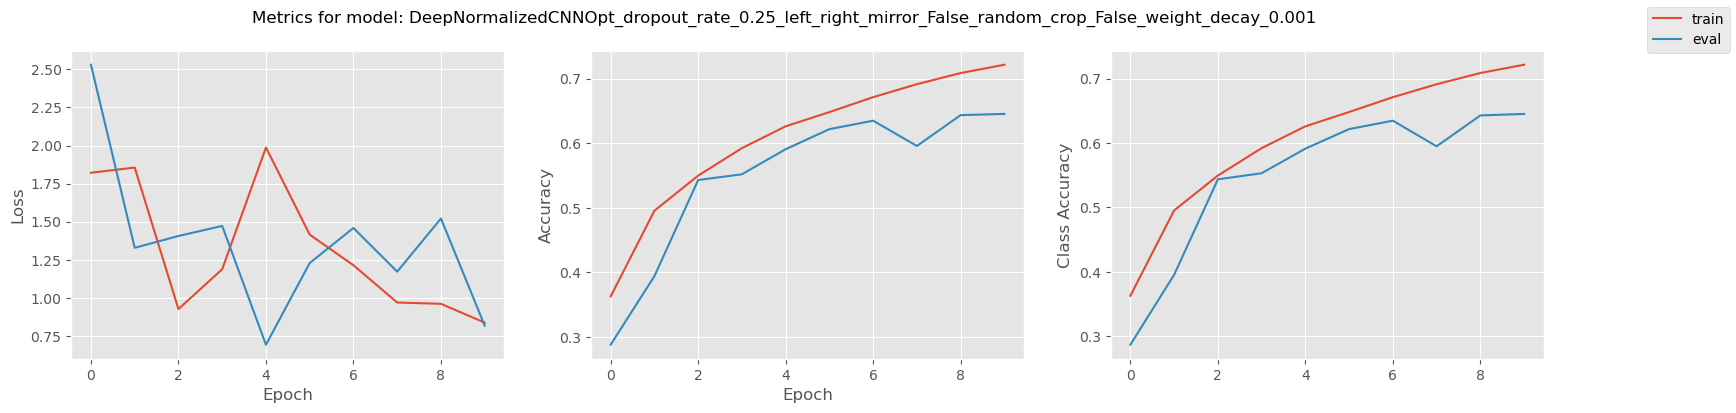

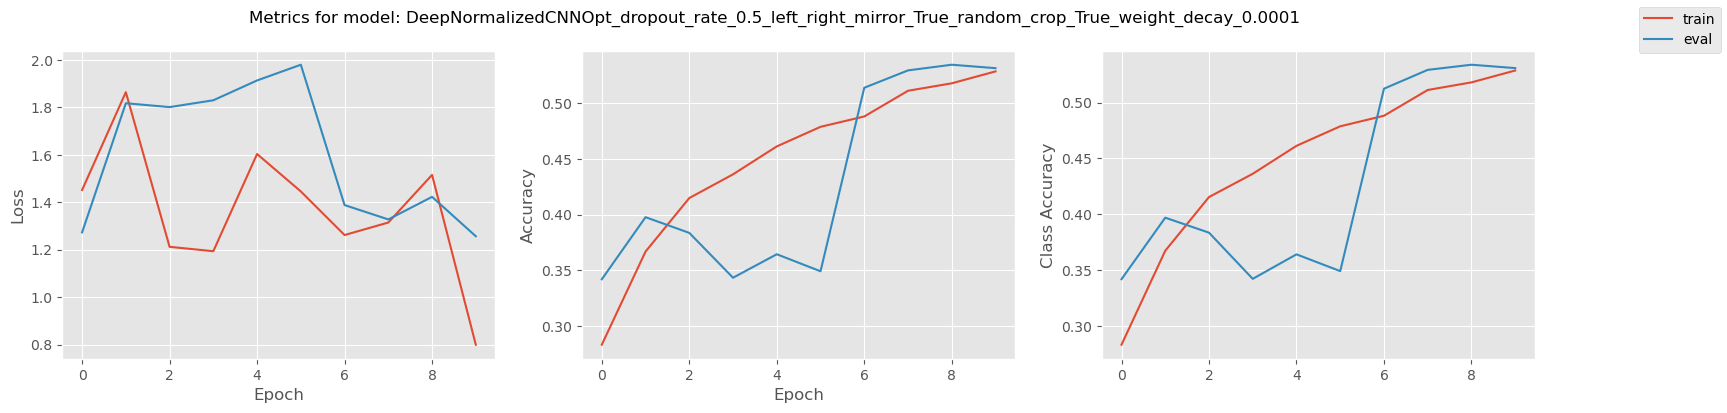

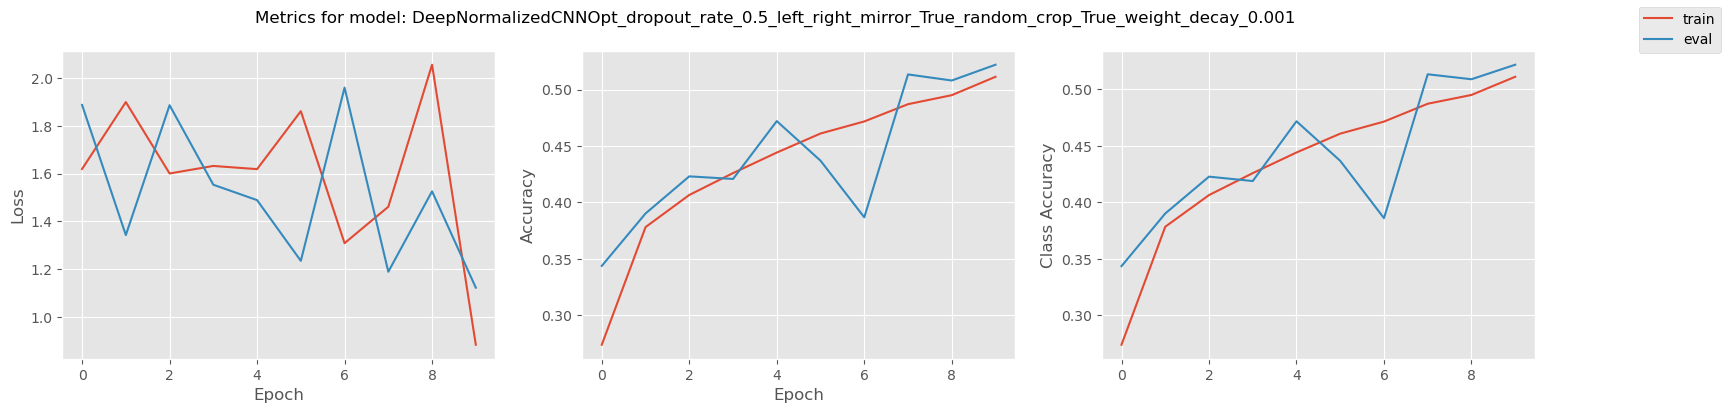

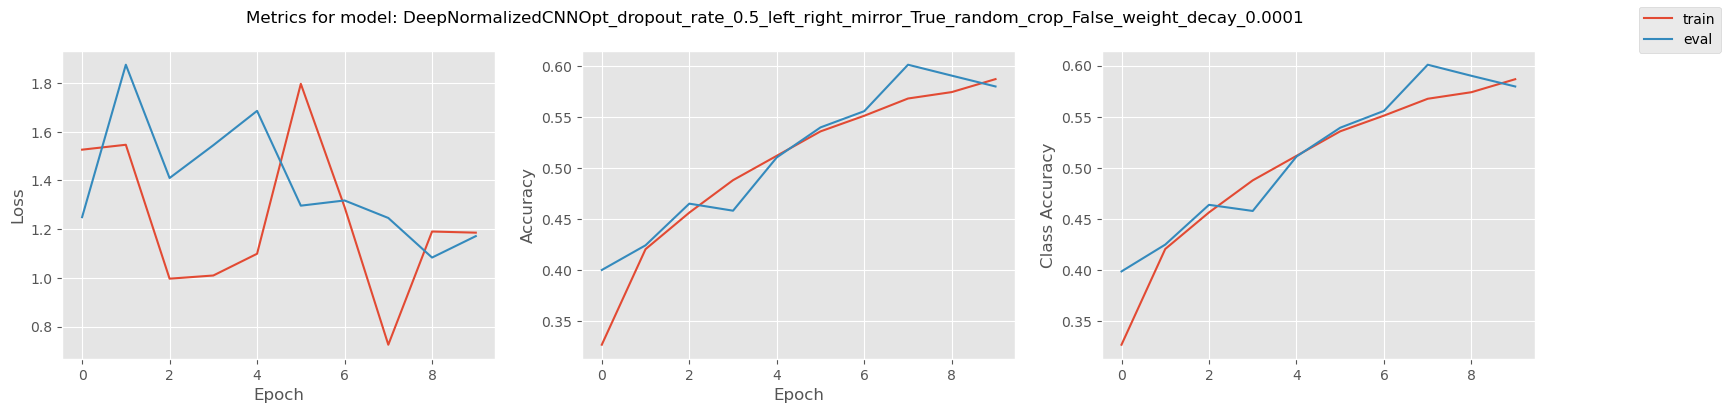

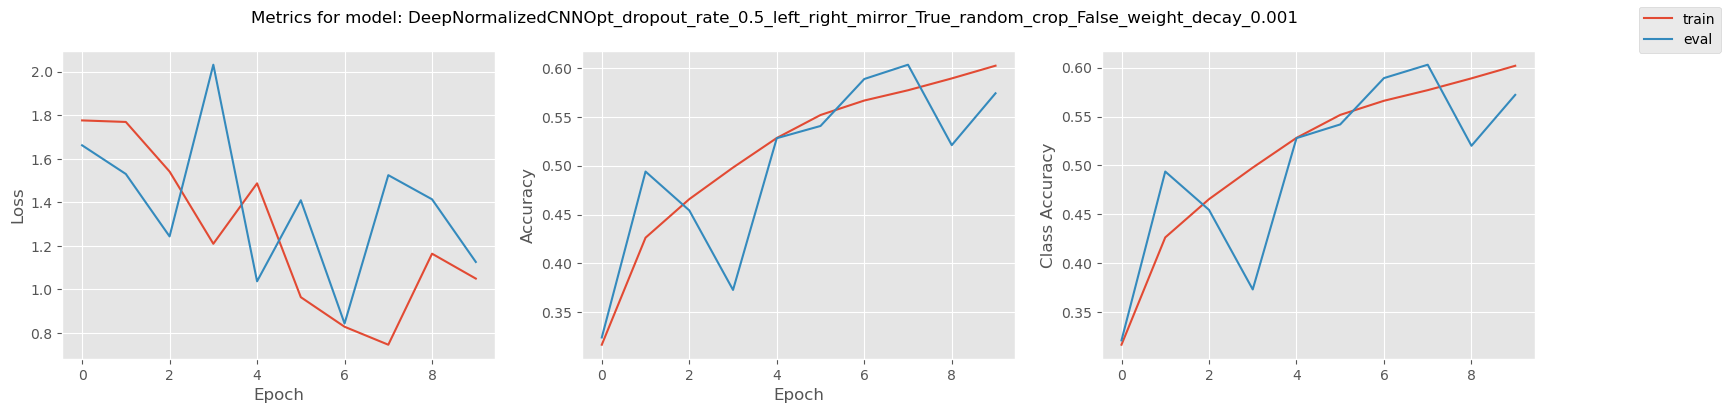

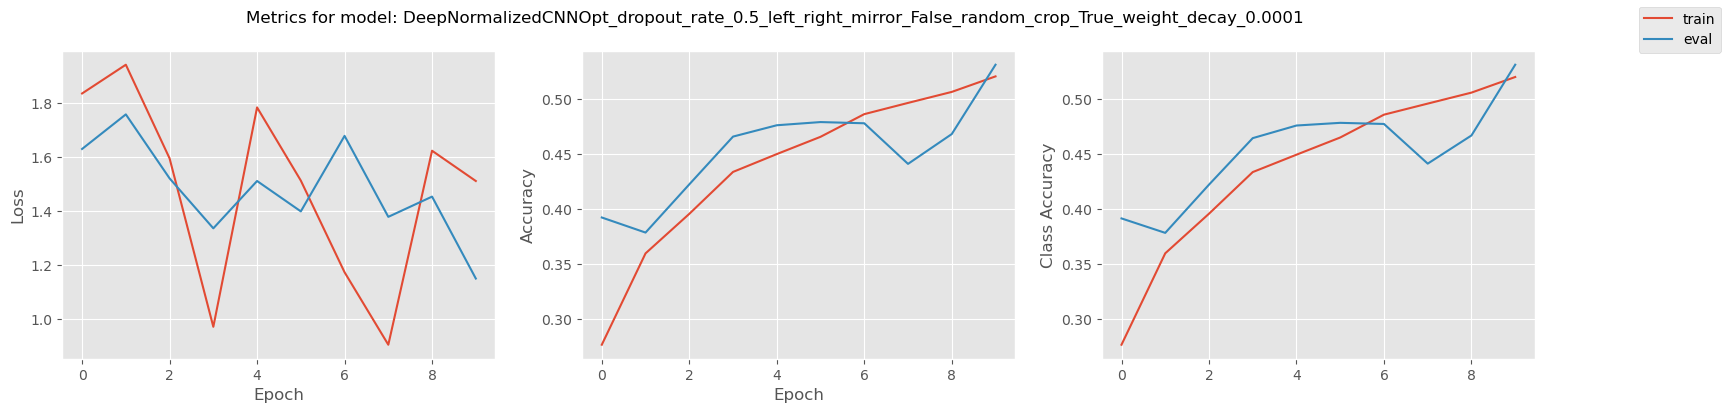

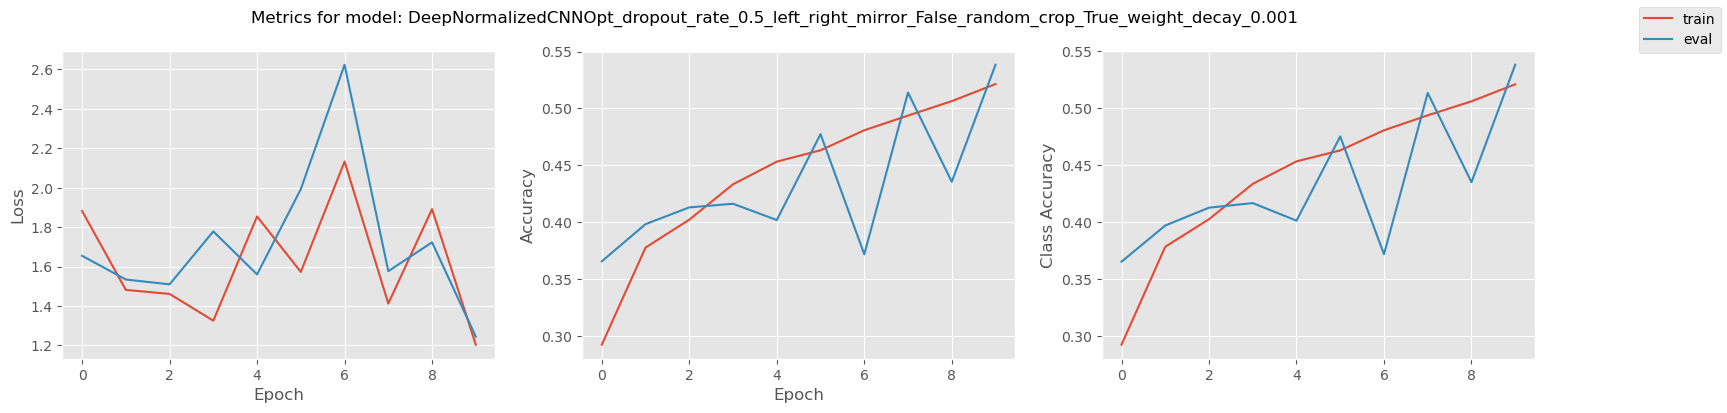

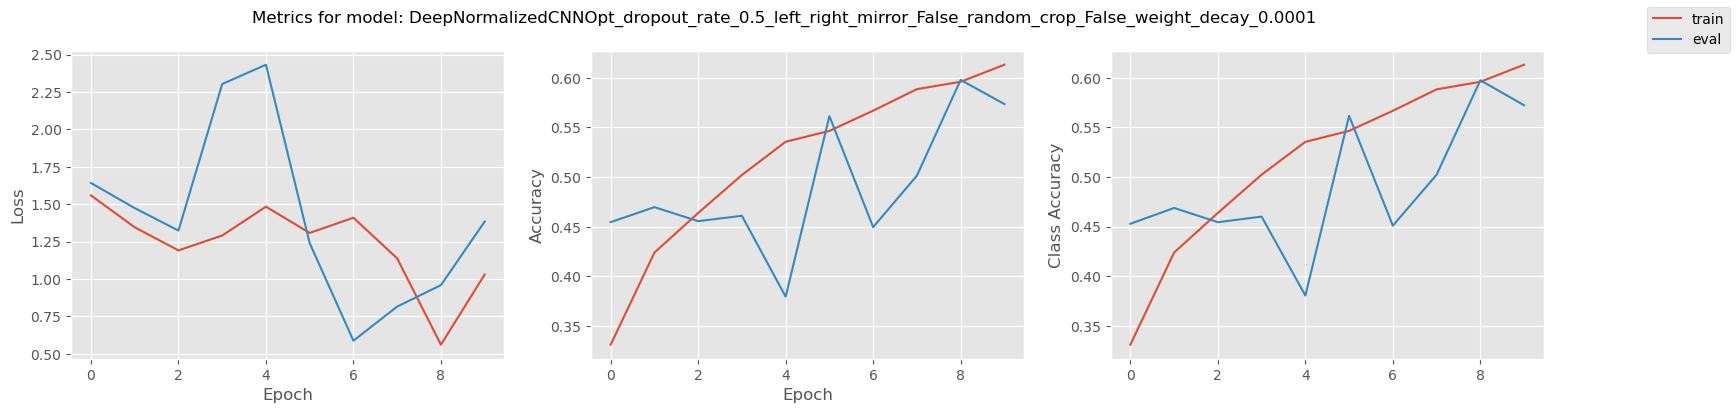

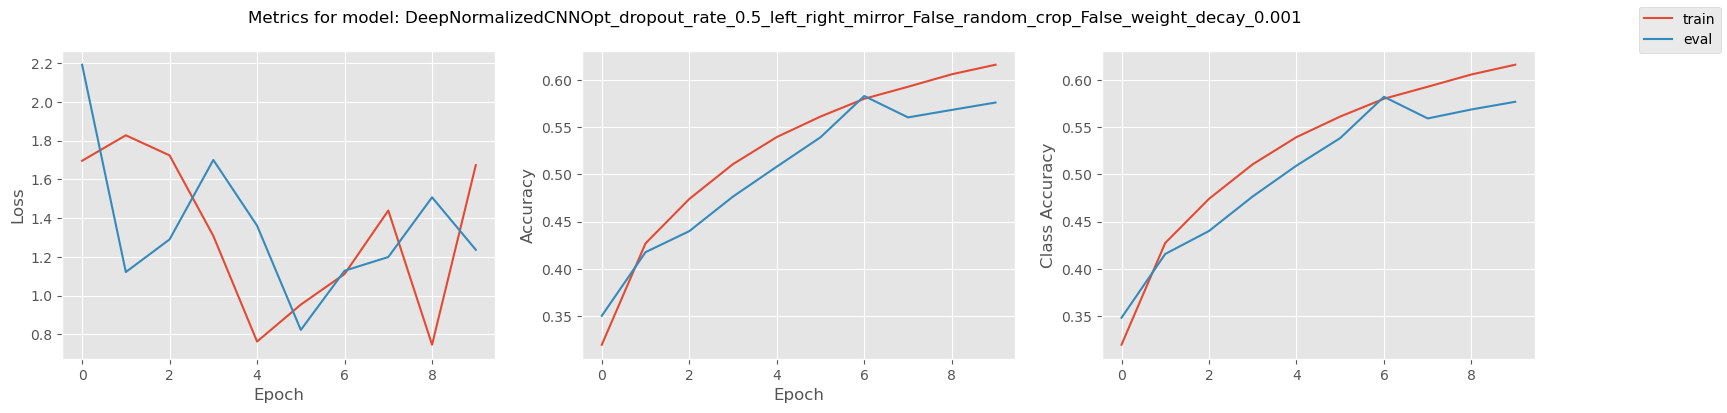

In [11]:
# Perform grid search for hyperparameter optimization
param_grid = {
    'random_crop': [True, False],
    'left_right_mirror': [True, False],
    'dropout_rate': [0.25, 0.5],
    'weight_decay': [0.0001, 0.001]
}

best_model_name = None
best_model = None
best_model_accuracy = 0.0
best_parameters = None

for i, params in enumerate(ParameterGrid(param_grid)):
        
    if params['random_crop'] == True and params['left_right_mirror'] == True:
        transform = v2.Compose([
            v2.ToImage(), 
            v2.RandomHorizontalFlip(),
            v2.RandomCrop(32, padding=4),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean = [0.485, 0.456,0.406], std = [0.229, 0.224, 0.225])
        ])
    elif params['random_crop'] == True and params['left_right_mirror'] == False:
        transform = v2.Compose([
            v2.ToImage(), 
            v2.RandomCrop(32, padding=4),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean = [0.485, 0.456,0.406], std = [0.229, 0.224, 0.225])
        ])
    elif params['random_crop'] == False and params['left_right_mirror'] == True:
        transform = v2.Compose([
            v2.ToImage(), 
            v2.RandomHorizontalFlip(),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean = [0.485, 0.456,0.406], std = [0.229, 0.224, 0.225])
        ])
    else:
        transform = v2.Compose([
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean = [0.485, 0.456,0.406], std = [0.229, 0.224, 0.225])
        ])

    train_data_opt, val_data_opt, test_data_opt = cifar_load(transform)

    model = DeepNormalizedCNNOpt(dropout_rate=params['dropout_rate'])

    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=params['weight_decay'])

    print(f'\n\n{i+1}/{len(ParameterGrid(param_grid))} Training model with hyperparameters: {params}')

    name = model.__class__.__name__

    for param in params:
        name += "_"+param + "_" + str(params[param])

    trainer = train_model_opt(model, optimizer, name, train_data_opt, val_data_opt)

    trainer.train()

    model, test_metric = test_model(model, params, test_data_opt)

    plot_metrics(trainer, name)

    if test_metric.accuracy() > best_model_accuracy:
        best_model_accuracy = test_metric.accuracy()
        best_parameters = params
        best_model = model
        best_model_name = name

print("Model:", best_model_name)
print("Best model found with parameters:", best_parameters)
print("Best test accuracy:", best_model_accuracy)
